In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import importlib
import lumped_parameter_model
import utils 
import stats
importlib.reload(lumped_parameter_model)
importlib.reload(utils)
importlib.reload(stats)
from lumped_parameter_model import *
from utils import *
from stats import *
from scipy import optimize
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [2]:
hinit = 10
A = 1.86e6 #m2
w = np.sqrt(A)
l = np.sqrt(A)
kbar = 1000. #m/d
b = 20.
hs = 372.5 #m
sy = 0.2
dt = 1. 
model = Model(w=w, l = l, kbar =kbar, b = b, hs = hs, sy = sy, dt = dt)

In [4]:
#optimize each timestep
# def optimize(objective, init_vals : tuple, *args):
#     result = optimize.minimize(objective, init_vals, args =tuple(args))
#     return result
def optimize_K_by_Q(K_0, ht, rt, dt, val_data, error_fun):
    def objective(args, ht, rt, dt, val_data, error_fun): #give recharge data and observed data (validation)
        K = args[0]
        # sy = args[1]
        h, Q = model.explicit_solve(ht, rt, dt, kbar = K)
        error = error_fun([val_data], [Q])
        print(error)
        return error
    params = (K_0)
    result = optimize.minimize(objective, params, args = (ht, rt, dt, val_data, error_fun), bounds = [(0, None)])
    return result

def optimize_K_by_h(K_0, ht, rt, dt, val_data, error_fun):
    def objective(args, ht, rt, dt, val_data, error_fun): #give recharge data and observed data (validation)
        K = args[0]
        # sy = args[1]
        h, Q = model.explicit_solve(ht, rt, dt, kbar = K)
        error = error_fun([val_data], [h])
        print(error)
        return error
    params = (K_0)
    result = optimize.minimize(objective, params, args = (ht, rt, dt, val_data, error_fun), bounds = [(0, None)])
    return result

def optimize_K(K_0, ht, rt, dt, Q_val, h_val, corr_coeff, Q_range, h_range, error_fun):
    def objective(args, ht, rt, dt, Q_val, h_val, error_fun): #give recharge data and observed data (validation)
        K = args[0]

        Q_min = Q_range[0]
        Q_max = Q_range[1]
        h_min = h_range[0]
        h_max = h_range[1]
        h, Q = model.explicit_solve(ht, rt, dt, kbar = K)
        h_error = (error_fun([h_val], [h]) - h_min)/(h_max-h_min)
        Q_error = (error_fun([Q_val], [Q]) - Q_min)/(Q_max- Q_min)
        total_error = np.sqrt(h_error**2 + Q_error**2 + 2*corr_coeff*h_error*Q_error)
        print(h_error, Q_error)
        print(total_error)
        return total_error
    params = (K_0)
    result = optimize.minimize(objective, params, args = (ht, rt, dt, Q_val, h_val, error_fun), bounds = [(0, None)])
    return result

def optimize_K_S(K_0, S_0, ht, rt, dt, Q_val, h_val, corr_coeff, Q_range, h_range, error_fun):
    def objective(args, ht, rt, dt, Q_val, h_val, error_fun): #give recharge data and observed data (validation)
        K = args[0]
        S = args[1]
        Q_min = Q_range[0]
        Q_max = Q_range[1]
        h_min = h_range[0]
        h_max = h_range[1]
        h, Q = model.explicit_solve(ht, rt, dt, kbar = K, sy = S)
        h_error = (error_fun([h_val], [h]) - h_min)/(h_max-h_min)
        Q_error = (error_fun([Q_val], [Q]) - Q_min)/(Q_max- Q_min)
        total_error = np.sqrt(h_error**2 + Q_error**2 + 2*corr_coeff*h_error*Q_error)
        print(h_error, Q_error)
        print(total_error)
        return total_error
    params = (K_0, S_0)
    result = optimize.minimize(objective, params, args = (ht, rt, dt, Q_val, h_val, error_fun), bounds = [(0, None), (0,1)])
    return result

def optimize_S(S_0, ht, rt, dt, Q_val, h_val, corr_coeff, Q_range, h_range, error_fun):
    def objective(args, ht, rt, dt, Q_val, h_val, error_fun): #give recharge data and observed data (validation)
        sy = args[0]

        Q_min = Q_range[0]
        Q_max = Q_range[1]
        h_min = h_range[0]
        h_max = h_range[1]
        h, Q = model.explicit_solve(ht, rt, dt, sy = sy)
        h_error = (error_fun([h_val], [h]) - h_min)/(h_max-h_min)
        Q_error = (error_fun([Q_val], [Q]) - Q_min)/(Q_max- Q_min)
        total_error = np.sqrt(h_error**2 + Q_error**2 + 2*corr_coeff*h_error*Q_error)
        print(h_error, Q_error)
        print(total_error)
        return total_error
    params = (sy)
    result = optimize.minimize(objective, params, args = (ht, rt, dt, Q_val, h_val, error_fun), bounds = [(0, 1)])
    return result

def optimize_S_by_Q(S_0, ht, rt, dt, val_data, error_fun):
    def objective(args, ht, rt, dt, val_data, error_fun): #give recharge data and observed data (validation)
        sy = args[0]
        # sy = args[1]
        h, Q = model.explicit_solve(ht, rt, dt, sy = sy)
        error = error_fun([val_data], [Q])
        print(error)
        return error
    params = (S_0)
    result = optimize.minimize(objective, params, args = (ht, rt, dt, val_data, error_fun), bounds = [(0, None)])
    return result


In [5]:
#get data 
Q = convert_df_to_date_time(pd.read_csv('discharge_full_year_2018.csv'), 'Date').set_index('Date')
h = convert_df_to_date_time(pd.read_csv('2018_MRSW_year_FINAL.csv'), 'datetime').set_index('datetime')
r = convert_hourly_to_daily(convert_df_to_date_time(pd.read_csv('2017_2021_simulated_recharge_hourly.csv'), 'DATE'), 'DATE').set_index('DATE')
#clean data
Q = Q.dropna()
h = h.dropna()
r = r.dropna()
r = r[(r.index >= '2018-01-01') & (r.index <= '2018-12-31')] #get 2018 data only
h = h[h['gw_elev[m]'] > h['gw_elev[m]'].quantile(0.05)] #get rid of outliers

In [10]:
#optimize K for each timestep 
Ks = pd.DataFrame(columns = ['K', 'h_pred'])
for date in h.index[:-1]:
    ht = h.loc[date]['gw_elev[m]']
    # try:
    next_date = add_to_timestamp(date, 1, 'day')
    print(next_date)
    Q_val = Q.loc[next_date]['Q [m3/day]']
    rt = r.loc[date]['RCH[m/day]']
    # except:
    #     print(f'skipping {date}')
    #     continue
    dt = subtract_timestamps(next_date, date, 'day')
    result = optimize_K_by_Q(model.kbar, ht, rt, dt, Q_val, mean_squared_error)
    print(result)
    K_cal = result.x[0]
    h_pred, Q_pred = model.explicit_solve(ht, rt, dt, kbar = K_cal)
    Ks.loc[date] = [K_cal, h_pred]
    previous_date = date

2018-01-19 00:00:00
45866082005.90029
45866082006.8229
45773867648.02882
45773867648.9505
45405938140.443214
45405938141.36118
43949066892.50497
43949066893.40809
38359130419.218636
38359130420.06237
19800160821.53975
19800160822.145927
23.280273743789426
23.280294529521825
3.902517332701532e-09
3.6380384425975833e-09
1.1599186697191738e-12
1.1598907535263314e-12
  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 1.1599186697191738e-12
        x: [ 5.729e+00]
      nit: 4
      jac: [-2.792e-09]
     nfev: 18
     njev: 9
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
2018-01-20 00:00:00
45708885812.07076
45708885812.990234
45616985930.78883
45616985931.707375
45250311180.88165
45250311181.7965
43798408584.78062
43798408585.68064
38227540656.81929
38227540657.66015
19731948248.060154
19731948248.664257
127.97577947391247
127.97582812549369
3.6593297764011934e-08
3.577523613078463e-08
1.155925664671487e-12
1.1560117156634604e-12


In [11]:
#optimize K for each timestep 
Ks_by_h = pd.DataFrame(columns = ['K'])
for date in h.index[:-1]:
    ht = h.loc[date]['gw_elev[m]']
    try:
        next_date = add_to_timestamp(date, 1, 'day')
        print(next_date)
        h_val = h.loc[next_date]['gw_elev[m]']
        rt = r.loc[date]['RCH[m/day]']
    except:
        print(f'skipping {date}')
        continue
    dt = subtract_timestamps(next_date, date, 'day')
    result = optimize_K_by_h(model.kbar, ht, rt, dt, h_val, mean_squared_error)
    print(result)
    K_cal = result.x[0]
    Ks_by_h.loc[date] = [K_cal]


2018-01-19 00:00:00
0.3209367005116796
0.3209367005182489
0.320936269532208
0.32093626953877735
0.32093583854941915
0.32093583855598845
0.3209341146210286
0.3209341146275979
0.32092721895383197
0.3209272189603368
0.3208996370257345
0.3208996370323034
0.3207893211666215
0.3207893211731893
0.32034824737957585
0.32034824738613915
0.31858698662073426
0.31858698662727947
0.31159049381682036
0.31159049382329335
0.2843813263054965
0.2843813263116804
0.18797351552852976
0.18797351553355734
6.765459331192649e-11
6.765468869232994e-11
  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 6.765459331192649e-11
        x: [ 2.163e+01]
      nit: 3
      jac: [ 9.538e-09]
     nfev: 26
     njev: 13
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
2018-01-20 00:00:00
0.3195897588128968
0.31958975881938806
0.3195893345700218
0.31958933457651306
0.31958891032742837
0.3195889103339196
0.31958721335987045
0.31958721336636164
0.31958042553469207
0.319

In [16]:
#optimize K for each timestep 
Ks_both = pd.DataFrame(columns = ['K', 'h_pred', 'Q_pred'])
h_data, Q_data =  h['gw_elev[m]'], Q[Q.index.isin(h.index)]['Q [m3/day]']
corr_coeff = np.corrcoef(Q_data, h_data)[0,1]
Q_range= [Q_data.min(), Q_data.max()]
h_range = [h_data.min(),h_data.max()]
for date in h.index[:-1]:
    ht = h.loc[date]['gw_elev[m]']
    try:
        next_date = add_to_timestamp(date, 1, 'day')
        print(next_date)
        h_val = h.loc[next_date]['gw_elev[m]']
        Q_val = Q.loc[next_date]['Q [m3/day]']
        rt = r.loc[date]['RCH[m/day]']
    except:
        print(f'skipping {date}')
        continue
    dt = subtract_timestamps(next_date, date, 'day')
    result = optimize_K(model.kbar, ht, rt, dt, Q_val, h_val, corr_coeff, Q_range, h_range, mean_squared_error)
    print(result)
    K_cal = result.x[0]
    h_pred, Q_pred = model.explicit_solve(ht, rt, dt, kbar = K_cal)
    Ks_both.loc[date] = [K_cal, h_pred, Q_pred]


2018-01-19 00:00:00
-94.9085868252249 2414190.767021806
2414138.833737396
-94.90858682522324 2414190.767070368
2414138.833785958
-94.9087516757957 2409337.004780602
2409285.071408623
-94.90875167579406 2409337.0048291157
2409285.071457136
-94.90940939229857 2389970.7976891566
2389918.863967901
-94.90940939229692 2389970.7977374746
2389918.864016219
-94.91201328582314 2313287.4392972477
2313235.504194965
-94.91201328582152 2313287.4393447842
2313235.5042425017
-94.92199730013245 2019057.5253116114
2019005.584945129
-94.92199730013095 2019057.525356022
2019005.5849895393
-94.95502840074606 1042194.1826810277
1042142.2257071048
-94.955028400745 1042194.1827129343
1042142.2257390114
-94.9892508113483 -0.0604897158789341
95.0223646626188
-94.98925081134833 -0.0604897151225154
95.02236466220457
-94.98925083402631 -0.05967255952171901
95.02191717016034
-94.98925083402634 -0.05967255835107881
95.02191716951927
-94.98925092461717 -0.05289097647549284
95.01820352113678
-94.9892509246172 -0.05289

In [38]:
#calibrate K and S
K_S = pd.DataFrame(columns = ['K', 'S'])
h_data, Q_data =  h['gw_elev[m]'], Q[Q.index.isin(h.index)]['Q [m3/day]']
corr_coeff = np.corrcoef(Q_data, h_data)[0,1]
Q_range= [Q_data.min(), Q_data.max()]
h_range = [h_data.min(),h_data.max()]
for date in h.index[:-1]:
    ht = h.loc[date]['gw_elev[m]']
    try:
        next_date = add_to_timestamp(date, 1, 'day')
        print(next_date)
        Q_val = Q.loc[next_date]['Q [m3/day]']
        h_val = h.loc[next_date]['gw_elev[m]']
        rt = r.loc[date]['RCH[m/day]']
    except:
        print(f'skipping {date}')
        continue
    dt = subtract_timestamps(next_date, date, 'day')
    try:
        result = optimize_K_S(model.kbar, model.sy, ht, rt, dt, Q_val, h_val, corr_coeff, Q_range, h_range, mean_squared_error)
    except ValueError:
        print(f"Skipping {date}")
        continue
    print(result)
    K_cal = result.x[0]
    S_cal = result.x[1]
    K_S.loc[date] = [K_cal, S_cal]
    previous_date = date

2018-01-19 00:00:00
-94.9085868252249 2414190.767021806
2414138.833737396
-94.90858682522324 2414190.767070368
2414138.833785958
-94.90858683342364 2414190.767021806
2414138.8337373915
-94.90913135241712 2409337.005306584
2409285.071726853
-94.9091313524155 2409337.005355097
2409285.071775366
-94.90913136054208 2409337.005306584
2409285.071726849
-94.91126633964294 2389970.800308471
2389918.8655711333
-94.91126633964133 2389970.80035679
2389918.865619452
-94.91126634748032 2389970.800308471
2389918.865571129
-94.9191614950052 2313287.450120442
2313235.511106819
-94.91916149500373 2313287.450167979
2313235.5111543564
-94.91916150180518 2313287.450120442
2313235.511106815
-94.94271743387179 2019057.566239056
2019005.614535065
-94.94271743387074 2019057.5662834672
2019005.6145794762
-94.94271743784071 2019057.566239056
2019005.6145350628
-94.97904612811575 1042194.3006451868
1042142.3305301415
-94.97904612811543 1042194.3006770936
1042142.3305620482
-94.97904612871162 1042194.3006451868
1

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy


-94.64412192721652 5262010.00437186
5261958.215093667
-94.64412192721146 5262010.004478619
5261958.215200426
-94.64412195229353 5262010.00437186
5261958.215093653
-94.65394182021635 5219394.048082173
5219342.253435464
-94.65394182021143 5219394.048188498
5219342.253541789
-94.65394184406843 5219394.048082173
5219342.253435451
-94.68908744937433 5050662.936599924
5050611.122741849
-94.68908744936999 5050662.9367045155
5050611.12284644
-94.68908746903323 5050662.936599924
5050611.122741839
-94.78412044269412 4403461.909494921
4403410.043727006
-94.7841204426912 4403461.909592578
4403410.043824663
-94.78412045263154 4403461.909494921
4403410.043727
-94.91155753803554 2258232.5022589266
2258180.567439276
-94.91155753803451 2258232.5023288634
2258180.5675092125
-94.91155753944865 2258232.5022589266
2258180.567439275
-94.96366945808643 -0.05922892644806871
94.9960928444051
-94.96366945808607 -0.05922892444822364
94.99609284330953
-94.96366945809086 -0.05922892644806871
94.99609284440953
-94.

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy


-94.65588507420571 4768222.450420031
4768170.654766883
-94.65824509898445 4758536.249879025
4758484.452935828
-94.65824509897972 4758536.249975838
4758484.453032641
-94.65824512240914 4758536.249879025
4758484.452935815
-94.66741929317745 4719889.930847533
4719838.128889687
-94.66741929317286 4719889.930943952
4719838.128986106
-94.66741931546635 4719889.930847533
4719838.128889675
-94.7002842532055 4566880.3848420195
4566828.564923017
-94.70028425320137 4566880.384936863
4566828.56501786
-94.70028427160373 4566880.3848420195
4566828.564923007
-94.78945455972139 3980053.8827472716
3980002.014136611
-94.78945455971865 3980053.8828358096
3980002.014225149
-94.78945456907614 3980053.8827472716
3980002.014136606
-94.91037030901249 2036134.7852052362
2036082.8511876275
-94.9103703090115 2036134.7852685638
2036082.8512509551
-94.91037031037077 2036134.7852052362
2036082.8511876268
-94.96106795331053 -0.05593332497835009
94.99168656631475
-94.96106795331016 -0.05593332179585721
94.99168656457

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy


-94.97949661579835 -0.04097585687092615
95.00192505992887
-94.9794966157937 -0.04097586338364824
95.00192506348999
-94.97949329797316 0.16369879853550515
94.89001517982996
-94.97949329797297 0.16369882031472624
94.89001516793836
-94.97949329796836 0.16369879853550515
94.89001517982516
-94.97948007501056 3.191270145262793
93.27145125402585
-94.97948007501036 3.1912702281080025
93.2714512106966
-94.97948007500594 3.191270145262793
93.27145125402123
-94.97942794504 50.64351871698296
79.50868163699714
-94.97942794503979 50.64351904409221
79.50868163152585
-94.97942794503604 50.64351871698296
79.50868163699378
-94.97937197285064 168.15294011140583
140.7748464629963
-94.97937197285044 168.15294070720535
140.77484695470173
-94.97937197284739 168.15294011140583
140.77484646299624
-94.97942730845719 51.58347309971321
79.49851515562818
-94.97942730845699 51.5834734298404
79.498515154009
-94.97942730845325 51.58347309971321
79.49851515562489
-94.9794270461546 51.97336919752986
79.49755888427347
-

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy


-94.76495674195807 6621200.120314075
6621148.264793094
-94.76495674195345 6621200.120448849
6621148.264927868
-94.76495676489627 6621200.120314075
6621148.264793082
-94.76723768885763 6607729.470958352
6607677.614190214
-94.76723768885306 6607729.47109299
6607677.614324852
-94.76723771147469 6607729.470958352
6607677.614190202
-94.77607009455328 6553984.041428133
6553932.179830839
-94.77607009454886 6553984.041562224
6553932.17996493
-94.7760701159397 6553984.041428133
6553932.179830827
-94.80723010703765 6341197.009589928
6341145.130958111
-94.8072301070338 6341197.009721825
6341145.131090008
-94.80723012425224 6341197.009589928
6341145.130958102
-94.88695489476403 5525163.862759722
5525111.940576279
-94.88695489476171 5525163.862882838
5525111.940699394
-94.88695490265502 5525163.862759722
5525111.940576274
-94.97389787600464 2822870.963800935
2822818.9945902154
-94.97389787600413 2822870.9638889367
2822818.994678217
-94.9738978767111 2822870.963800935
2822818.994590215
-94.989187546

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy


-94.98735658038946 1.1306549732272044
94.37339992165359
-94.98735658038957 1.130655031969685
94.3733998900041
-94.98735658038889 1.1306549732272044
94.37339992165302
-94.9873684288142 17.181750553402395
86.78523446330162
-94.98736842881429 17.181750776845774
86.78523437371362
-94.98736842881347 17.181750553402395
86.78523446330091
-94.98741557318404 268.7541229032665
230.89593076177627
-94.98741557318414 268.75412378551346
230.89593159007285
-94.98741557318277 268.7541229032665
230.89593076177655
-94.98737431982373 32.16333450377961
81.93612621547624
-94.98737431982383 32.163334809240894
81.93612614160755
-94.98737431982293 32.16333450377961
81.9361262154755
-94.987380985801 54.747794577348216
79.55245936425257
-94.9873809858011 54.74779497572011
79.55245937812431
-94.98738098580013 54.747794577348216
79.55245936425186
-94.98737993243931 50.780372120802504
79.51323086978165
-94.98737993243941 50.78037250448539
79.51323086400411
-94.98737993243846 50.780372120802504
79.51323086978093
-9

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy


-94.9885926642539 51.97838060778383
79.50523048524185
-94.98859266425396 51.97838022037239
79.50523048524187
-94.988592664253 51.97838060778383
79.50523048524111
-94.98859265837825 51.97834782835174
79.50523048032679
-94.98859265837831 51.9783474409406
79.50523048032696
-94.98859265837734 51.97834782835174
79.50523048032603
-94.98859263488457 51.978216710727125
79.50523046080909
-94.98859263488463 51.97821632331648
79.5052304608099
-94.98859263488367 51.978216710727125
79.50523046080835
-94.98859254105238 51.977692241880725
79.50523038501953
-94.98859254105245 51.97769185447222
79.50523038502291
-94.9885925410515 51.977692241880725
79.50523038501879
-94.9885921679896 51.97559439292425
79.50523011834763
-94.98859216798965 51.97559400552337
79.50523011836121
-94.98859216798871 51.97559439292425
79.50523011834689
-94.98858902135619 51.96813936819588
79.50522809426133
-94.98858902135626 51.968138980822744
79.50522809431124
-94.98858902135538 51.96813936819588
79.50522809426064
-94.98858100

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy


-94.9886767180694 51.97879444309374
79.5053008389843
-94.98867628698103 51.98002046971132
79.50530049344121
-94.98867628698098 51.980020854831466
79.50530049344894
-94.98867628698477 51.98002046971132
79.50530049344434
-94.9886745484269 51.98492472060352
79.50529928852995
-94.98867454842684 51.98492510574182
79.50529928856145
-94.9886745484307 51.98492472060352
79.50529928853312
-94.98865695650598 52.00595516106943
79.50528907060269
-94.9886569565059 52.005955546285534
79.50528907073611
-94.98865695651027 52.00595516106943
79.50528907060627
-94.98852741799253 52.06970422158153
79.50522837563483
-94.98852741799243 52.06970460703415
79.50522837607772
-94.98852741800161 52.06970422158153
79.50522837564245
Skipping 2018-06-26 00:00:00
2018-06-28 00:00:00
-94.78291014217693 6639770.610459803
6639718.745113456
-94.7829101421724 6639770.610597913
6639718.745251566
-94.78291016461816 6639770.610459803
6639718.745113444
-94.78514275535831 6625966.861500104
6625914.994933067
-94.78514275535382 6

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy


-94.90917739192024 2844603.4771506856
2844551.5433453675
-94.90917739981437 2844603.477092094
2844551.5432867715
-94.93924832252333 2481976.395293608
2481924.4451961545
-94.93924832252216 2481976.395348338
2481924.4452508846
-94.93924832678668 2481976.395293608
2481924.445196152
-94.9802558049393 1278626.881609378
1278574.9102717557
-94.98025580493899 1278626.8816486602
1278574.910311038
-94.98025580546047 1278626.881609378
1278574.9102717554
-94.98911604430005 -0.06003320221197415
95.0219798855763
-94.98911604430008 -0.06003320109044858
95.02197988496212
-94.98911604430015 -0.06003320221197415
95.02197988557639
-94.98911607211852 -0.05857918627790091
95.02118363083464
-94.98911607211853 -0.058579184542224945
95.02118362988412
-94.98911607211862 -0.05857918627790091
95.02118363083474
-94.98911618337176 -0.046512358171127414
95.01457602164943
-94.98911618337179 -0.0465123539788494
95.014576019354
-94.98911618337188 -0.046512358171127414
95.01457602164955
-94.98911662805509 0.10176718418

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy


-94.82841357199548 5010664.381387809
5010612.49129639
-94.82841357199212 5010664.381489608
5010612.491398189
-94.82841358862775 5010664.381387809
5010612.491296382
-94.83491424597443 4970027.2587389015
4969975.365095498
-94.83491424597118 4970027.258840288
4969975.365196885
-94.83491426169623 4970027.2587389015
4969975.36509549
-94.8578294216477 4809133.345421662
4809081.43926045
-94.85782942164488 4809133.345521394
4809081.439360183
-94.85782943428454 4809133.345421662
4809081.439260444
-94.91626909578007 4192030.9286069353
4191978.9905645647
-94.91626909577839 4192030.9287000475
4191978.9906576765
-94.91626910153622 4192030.9286069353
4191978.9905645614
-94.97911411910546 2147193.0446157036
2147141.072903011
-94.9791141191051 2147193.0446823426
2147141.07296965
-94.97911411960033 2147193.0446157036
2147141.0729030105
-94.98905425392107 -0.03725548322992977
95.00944581204085
-94.9890542539211 -0.037255476211024166
95.00944580819815
-94.98905425392088 -0.03725548322992977
95.0094458120

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  h = ht + (qin - qs) * dt / w / l / sy


Skipping 2018-10-09 00:00:00
2018-10-11 00:00:00
-94.71262917400166 5662622.146962441
5662570.3201552555
-94.7126291739968 5662622.147080469
5662570.320273283
-94.7126291977272 5662622.146962441
5662570.3201552415
-94.71499729993783 5650825.436688068
5650773.608586215
-94.71499729993305 5650825.436805975
5650773.608704122
-94.71499732334982 5650825.436688068
5650773.608586202
-94.72418583516422 5603761.601781754
5603709.768656654
-94.72418583515959 5603761.601899168
5603709.768774069
-94.72418585737307 5603761.601781754
5603709.768656642
-94.75686316253831 5417474.361215136
5417422.510228479
-94.75686316253423 5417474.361330583
5417422.510343926
-94.75686318064787 5417474.361215136
5417422.510228469
-94.84312729434868 4703814.983886956
4703763.085785311
-94.84312729434605 4703814.983994529
4703763.085892883
-94.84312730311858 4703814.983886956
4703763.085785305
-94.94957580361996 2353010.833586922
2352958.87790822
-94.9495758036192 2353010.833663004
2352958.877984302
-94.94957580466803

Text(0.5, 1.0, 'Predicted head using calibrated K')

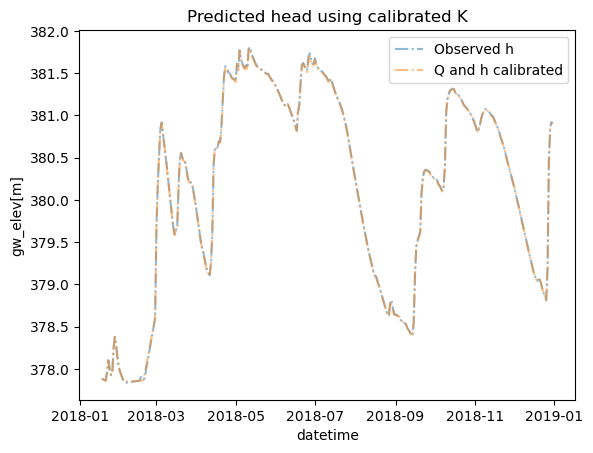

In [18]:
# sns.lineplot(Ks, x = Ks.index, y = 'h_pred', linestyle = '-.', alpha = 0.5, label = 'Q calibrated')
sns.lineplot(h, x = h.index, y = 'gw_elev[m]', linestyle = '-.', alpha = 0.5, label = 'Observed h')
sns.lineplot(Ks_both, x = Ks_both.index, y = 'h_pred', linestyle = '-.', alpha = 0.5, label = 'Q and h calibrated')
plt.title("Predicted head using calibrated K")
# plt.savefig("predicted_h_calibated_k.png", bbox_inches = 'tight')

Text(0.5, 1.0, 'Predicted Q using calibrated K')

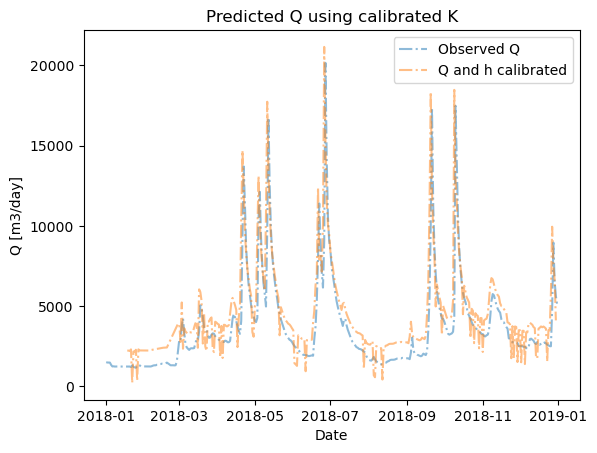

In [17]:
# sns.lineplot(Ks, x = Ks.index, y = 'h_pred', linestyle = '-.', alpha = 0.5, label = 'Q calibrated')
sns.lineplot(Q, x = Q.index, y = 'Q [m3/day]', linestyle = '-.', alpha = 0.5, label = 'Observed Q')
sns.lineplot(Ks_both, x = Ks_both.index, y = 'Q_pred', linestyle = '-.', alpha = 0.5, label = 'Q and h calibrated')
plt.title("Predicted Q using calibrated K")
# plt.savefig("predicted_h_calibated_k.png", bbox_inches = 'tight')

<Axes: xlabel='None', ylabel='K'>

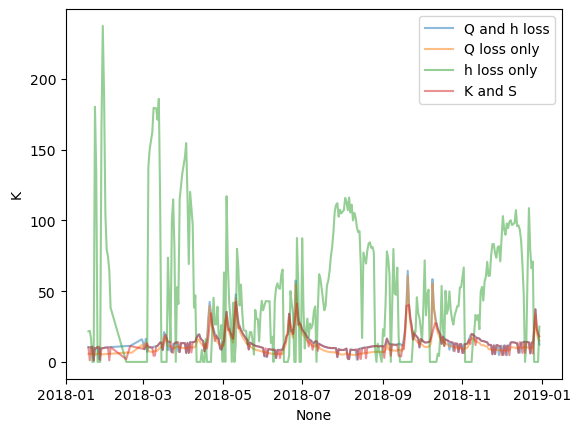

In [16]:
sns.lineplot(Ks_both, x = Ks_both.index, y = 'K', alpha = 0.5, label = 'Q and h loss')
sns.lineplot(Ks, x = Ks.index, y = 'K', alpha = 0.5, label = 'Q loss only')
sns.lineplot(Ks_by_h, x = Ks_by_h.index, y = 'K', alpha = 0.5, label = 'h loss only')
sns.lineplot(K_S, x = K_S.index, y = 'K', alpha = 0.5, label = 'K and S')

In [21]:
S = pd.DataFrame(columns = ['S'])
h_data, Q_data =  h['gw_elev[m]'], Q[Q.index.isin(h.index)]['Q [m3/day]']
corr_coeff = np.corrcoef(Q_data, h_data)[0,1]
Q_range= [Q_data.min(), Q_data.max()]
h_range = [h_data.min(),h_data.max()]
for date in h.index[:-1]:
    ht = h.loc[date]['gw_elev[m]']
    try:
        next_date = add_to_timestamp(date, 1, 'day')
        print(next_date)
        Q_val = Q.loc[next_date]['Q [m3/day]']
        h_val = h.loc[next_date]['gw_elev[m]']
        rt = r.loc[date]['RCH[m/day]']
    except:
        print(f'skipping {date}')
        continue
    dt = subtract_timestamps(next_date, date, 'day')
    try:
        result = optimize_S(model.sy, ht, rt, dt, Q_val, h_val, corr_coeff, Q_range, h_range, mean_squared_error)
    except ValueError:
        print(f"Skipping {date}")
        continue
    print(result)
    S_cal = result.x[0]
    S.loc[date] = [S_cal]
    previous_date = date

2018-01-19 00:00:00
-94.9085868252249 2414190.767021806
2414138.833737396
-94.90858683342364 2414190.767021806
2414138.8337373915
-94.98252557288936 2414190.767021806
2414138.7932796734
-94.98252557310336 2414190.767021806
2414138.7932796734
  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 2414138.7932796734
        x: [ 6.657e-01]
      nit: 1
      jac: [ 0.000e+00]
     nfev: 4
     njev: 2
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
2018-01-20 00:00:00
-94.9089254535821 2405916.6439060313
2405864.710440826
-94.90892546174675 2405916.6439060313
2405864.7104408215
-94.98255499156622 2405916.6439060313
2405864.6701523033
-94.98255499177934 2405916.6439060313
2405864.670152303
-94.98353912265044 2405916.6439060313
2405864.6696138075
-94.98353912281993 2405916.6439060313
2405864.6696138075
  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 2405864.6696138075
        x: [ 7.174

Text(0.5, 1.0, 'Calibrated K vs. time')

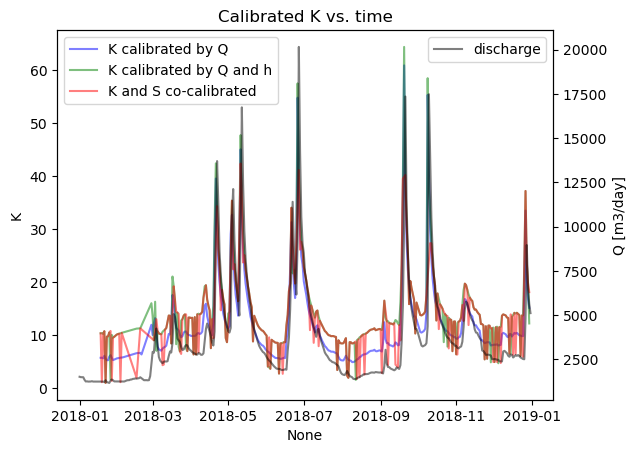

In [29]:
fig, ax = plt.subplots()
sns.lineplot(Ks, x = Ks.index, y = 'K', color = 'blue', alpha = 0.5, label = "K calibrated by Q") 
sns.lineplot(Ks_both, x = Ks_both.index, y = 'K', color = 'green', alpha = 0.5, label = "K calibrated by Q and h") 
sns.lineplot(K_S, x = K_S.index, y = 'K', color = 'red', alpha = 0.5, label = "K and S co-calibrated") 
# sns.lineplot(Ks_by_h, x = Ks_by_h.index, y = 'K')
sns.lineplot(Q, x = Q.index, y = 'Q [m3/day]', ax = ax.twinx(), color = 'black', alpha = 0.5, label = 'discharge')
plt.title("Calibrated K vs. time")

C:\Users\huan1428\AppData\Local\Temp\ipykernel_10580\3178013638.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cal_Q_results = model.explicit_solve_over_time(len(r.index), h.iloc[0]['gw_elev[m]'], r['RCH[m/day]'], kbar = Ks.mean()[0])
C:\Users\huan1428\AppData\Local\Temp\ipykernel_10580\3178013638.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cal_h_results = model.explicit_solve_over_time(len(r.index), h.iloc[0]['gw_elev[m]'], r['RCH[m/day]'], kbar = Ks_by_h.mean()[0])
C:\Users\huan1428\AppData\Local\Temp\ipykernel_10580\3178013638.py:4: FutureWarning: Series.__getitem__ treating keys as positions is depre

(0.0, 21108.8026663)

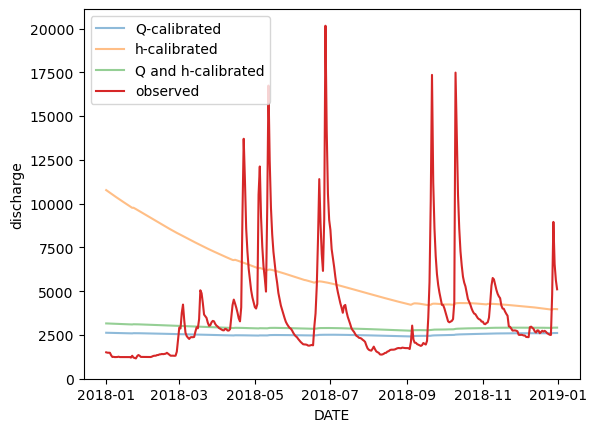

In [11]:
Ks_both.mean()
cal_Q_results = model.explicit_solve_over_time(len(r.index), h.iloc[0]['gw_elev[m]'], r['RCH[m/day]'], kbar = Ks.mean()[0])
cal_h_results = model.explicit_solve_over_time(len(r.index), h.iloc[0]['gw_elev[m]'], r['RCH[m/day]'], kbar = Ks_by_h.mean()[0])
cal_both_results = model.explicit_solve_over_time(len(r.index), h.iloc[0]['gw_elev[m]'], r['RCH[m/day]'], kbar = Ks_both.mean()[0])
sns.lineplot(cal_Q_results, x = r.index, y = 'discharge', label = 'Q-calibrated', alpha = 0.5)
sns.lineplot(cal_h_results, x = r.index, y = 'discharge', label = 'h-calibrated', alpha =0.5)
sns.lineplot(cal_both_results, x = r.index, y = 'discharge', label = 'Q and h-calibrated', alpha =0.5)

sns.lineplot(data = Q, x = Q.index, y = 'Q [m3/day]', label = 'observed')
plt.ylim(0, None)

<Axes: xlabel='DATE', ylabel='head'>

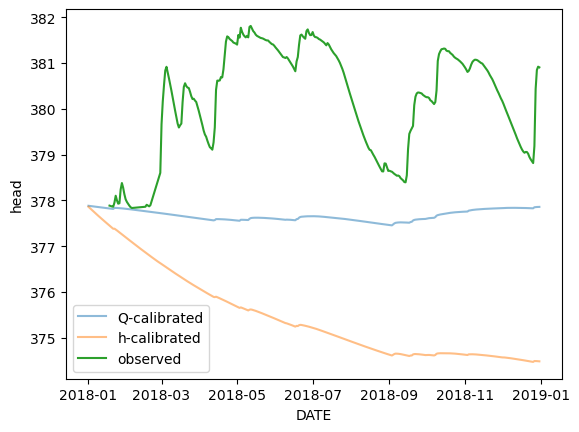

In [12]:
sns.lineplot(cal_Q_results, x = r.index, y = 'head', label = 'Q-calibrated', alpha = 0.5)
sns.lineplot(cal_h_results, x = r.index, y = 'head', label = 'h-calibrated', alpha =0.5)
sns.lineplot(data = h, x = h.index, y = 'gw_elev[m]', label = 'observed')


### Curve Fitting 
- K vs. h looks exponential
- So fit a curve using ln y = m x + b 
- Optimize params using gradient descent 
- Using curve, find elbow and define high K above elbow

Text(0, 0.5, 'Conductivity (m/d)')

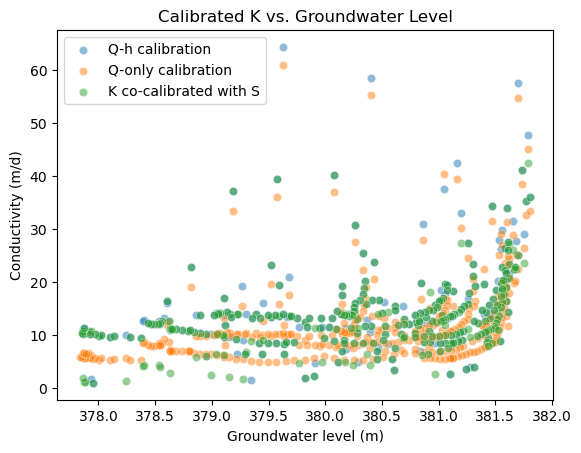

In [40]:
K_vs_h = Ks_both.join(h['gw_elev[m]'])
K_Q_vs_h = Ks.join(h['gw_elev[m]'])
K_h_vs_h = Ks_by_h.join(h['gw_elev[m]'])
K_S_vs_h = K_S.join(h['gw_elev[m]'])
# S_vs_h = S.join(h['gw_elev[m]'])
sns.scatterplot(K_vs_h, y = 'K', x = 'gw_elev[m]', label = 'Q-h calibration',alpha = 0.5)
sns.scatterplot(K_Q_vs_h, y = 'K', x = 'gw_elev[m]', label = 'Q-only calibration', alpha = 0.5)
sns.scatterplot(K_S_vs_h, y = 'K', x = 'gw_elev[m]', label = 'K co-calibrated with S', alpha = 0.5)
plt.title("Calibrated K vs. Groundwater Level")
plt.xlabel("Groundwater level (m)")
plt.ylabel("Conductivity (m/d)")
# plt.savefig('figs/kcal_vs_h.png', bbox_inches = 'tight', transparent = True)
# plt.yscale('log')
# sns.scatterplot(K_h_vs_h, y = 'K', x = 'gw_elev[m]', label = 'h only', alpha = 0.5)

<Axes: xlabel='gw_elev[m]', ylabel='S'>

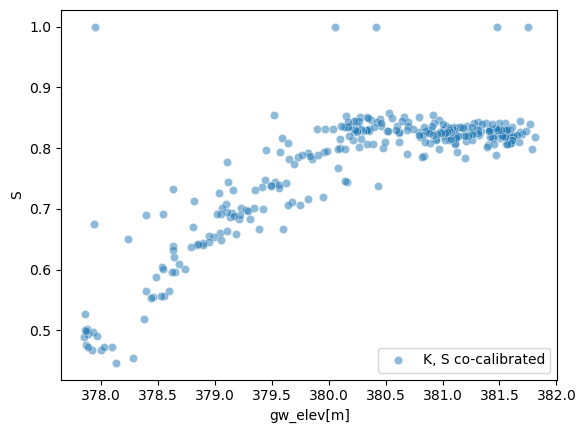

In [41]:
sns.scatterplot(K_S_vs_h, y = 'S', x = 'gw_elev[m]', label = 'K, S co-calibrated', alpha = 0.5)


<Axes: xlabel='S', ylabel='K'>

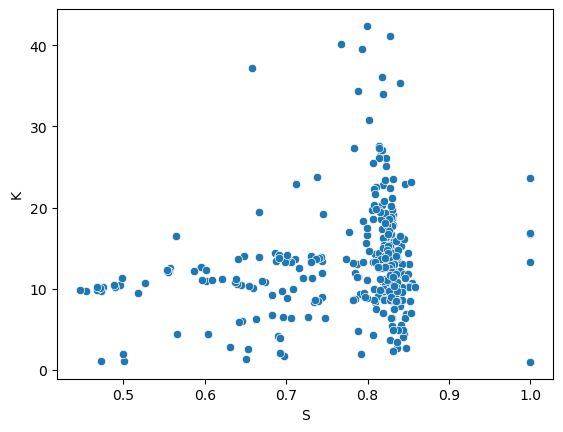

In [81]:
sns.scatterplot(K_S_vs_h, y = 'K', x = 'S')

## Variable K Model

In [2]:
importlib.reload(lumped_parameter_model)
from lumped_parameter_model import *

A = 1.86e6 #m2
w = np.sqrt(A)
l = np.sqrt(A)
hk = 381
K1 = 500
K2 = 1
kbar = K1 #m/d
b = 50
hs = 371.5 #m
sy = 0.1
dt = 1. 
varKmodel = TwoLayerKModel(K1, K2, hk, w=w, l = l, b = b, hs = hs, sy = sy, dt = dt)
model = Model(w =w, kbar = kbar, l = l, hs=hs, b=b, sy=sy, dt= dt)

k: 10.0
k = 10.0, qs: 9500.0, qin: 1737.84543, h: 380.9582679861828
k: 10
k = 10, qs: 9458.267986182818, qin: 1737.84543, h: 380.9167603380313
k: 10
k = 10, qs: 9416.760338031281, qin: 1737.84543, h: 380.8754758492784
k: 10
k = 10, qs: 9375.475849278417, qin: 1737.84543, h: 380.8344133201425
k: 10
k = 10, qs: 9334.413320142517, qin: 1737.84543, h: 380.7935715572923
k: 10
k = 10, qs: 9293.571557292296, qin: 1737.84543, h: 380.7529493738122
k: 10
k = 10, qs: 9252.949373812215, qin: 1737.84543, h: 380.7125455891681
k: 10
k = 10, qs: 9212.545589168087, qin: 1737.84543, h: 380.6723590291726
k: 10
k = 10, qs: 9172.359029172583, qin: 1737.84543, h: 380.6323885259512
k: 10
k = 10, qs: 9132.388525951228, qin: 1737.84543, h: 380.5926329179085
k: 10
k = 10, qs: 9092.632917908475, qin: 1737.84543, h: 380.55309104969393
k: 10
k = 10, qs: 9053.091049693932, qin: 1737.84543, h: 380.5137617721687
k: 10
k = 10, qs: 9013.76177216872, qin: 1737.84543, h: 380.4746439423721
k: 10
k = 10, qs: 8974.643942372

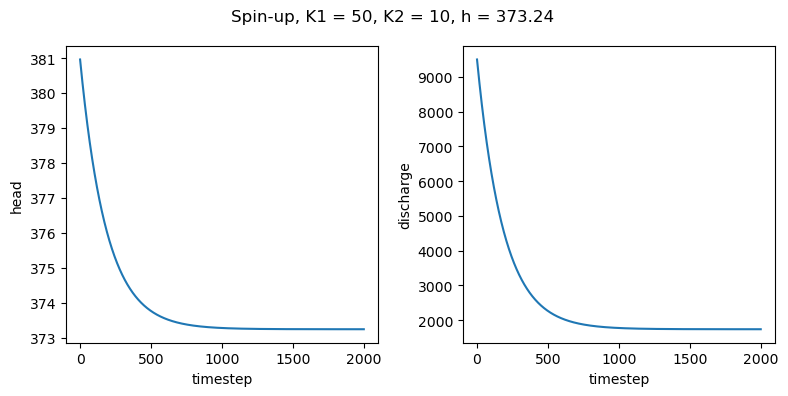

In [381]:
base_r = pd.Series(np.ones(2000) * r['RCH[m/day]'].quantile(.5))
spin_up = varKmodel.explicit_solve_over_time(len(base_r), h0 =varKmodel.hk, r = base_r, verbose = True)
h_o = np.round(spin_up['head'][spin_up.shape[0]-1], 2)
fig,ax = plt.subplots(1,2, figsize = (8,4))
sns.lineplot(spin_up, x = 'timestep', y = 'head', ax = ax[0])
sns.lineplot(spin_up, x = 'timestep', y = 'discharge', ax = ax[1])
plt.suptitle(f"Spin-up, K1 = {K1}, K2 = {K2}, h = {h_o} ")
plt.tight_layout()


<Axes: xlabel='DATE', ylabel='RCH[m/day]'>

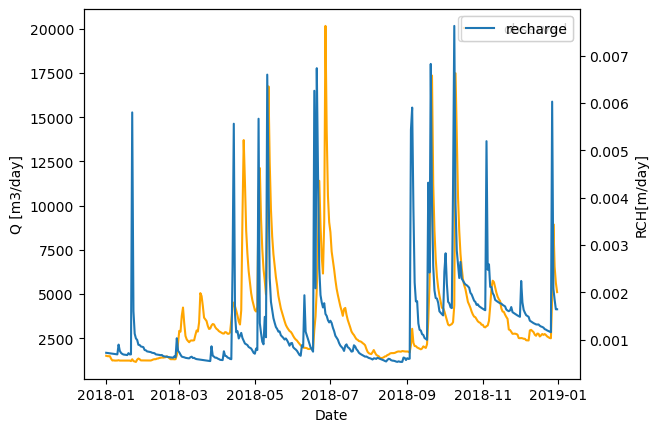

In [382]:
fig, ax = plt.subplots()
sns.lineplot(Q, x = Q.index, y ='Q [m3/day]', label = 'observed', color = 'orange')
sns.lineplot(r, x = r.index, y = 'RCH[m/day]', ax = ax.twinx(), label = 'recharge')

k: 1.0
k = 1.0, qs: 949.9999999999999, qin: 1253.4474899999998, h: 381.0016314381183
k: 1.085678720157819
k = 1.085678720157819, qs: 1031.5719059147568, qin: 1330.3863899999997, h: 381.0032379676026
k: 1.1700205592255246
k = 1.1700205592255246, qs: 1111.898380130765, qin: 1277.1699299999998, h: 381.0041265243223
k: 1.2166570101488388
k = 1.2166570101488388, qs: 1156.3262161158266, qin: 1279.8948299999997, h: 381.0047908717088
k: 1.2515199981730336
k = 1.2515199981730336, qs: 1189.5435854396053, qin: 10791.91809, h: 381.05641654108814
k: 3.945858825004336
k = 3.945858825004336, qs: 3770.827054407005, qin: 2980.2993899999997, h: 381.05216639235476
k: 3.7251440893933085
k = 3.7251440893933085, qs: 3558.319617738175, qin: 2092.33632, h: 381.04428476172177
k: 3.3153223788742547
k = 3.3153223788742547, qs: 3164.2380860884714, qin: 1906.6804199999997, h: 381.0375236990009
k: 2.963227184787645
k = 2.963227184787645, qs: 2826.18495004358, qin: 1847.8709399999996, h: 381.0322639462587
k: 2.68897

Text(0.5, 1.0, 'K_avg = 500, K1 = 500, K2 = 1')

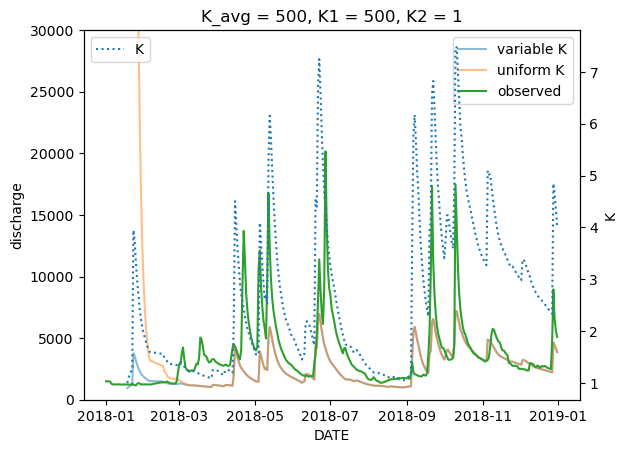

In [5]:
out_vark = varKmodel.explicit_solve_over_time(len(h), h0 =hk, r = r[r.index.isin(h.index)]['RCH[m/day]'], sy = sy, verbose = True)
out = model.explicit_solve_over_time(len(h), h0 =hk, r = r[r.index.isin(h.index)]['RCH[m/day]'],sy = sy, verbose = True)

dates = r[r.index.isin(h.index)]['RCH[m/day]'].index
fig, ax = plt.subplots()
twin = ax.twinx()
sns.lineplot(out_vark, x = dates, y = 'discharge', label = 'variable K', ax = ax,alpha = 0.5)
sns.lineplot(out_vark, x = dates, y = 'K', linestyle = ':', label = 'K', ax = twin)
sns.lineplot(out, x = dates, y = 'discharge', label = 'uniform K', ax = ax,alpha = 0.5)
ax.set_ylim(0, 30000)
sns.lineplot(Q, x = Q.index, y ='Q [m3/day]', label = 'observed', ax = ax)
twin.legend(loc = 'upper left')
plt.title(f"K_avg = {kbar}, K1 = {K1}, K2 = {K2}")


Text(0.5, 1.0, 'K_avg = 1000, K1 = 1000, K2 = 1')

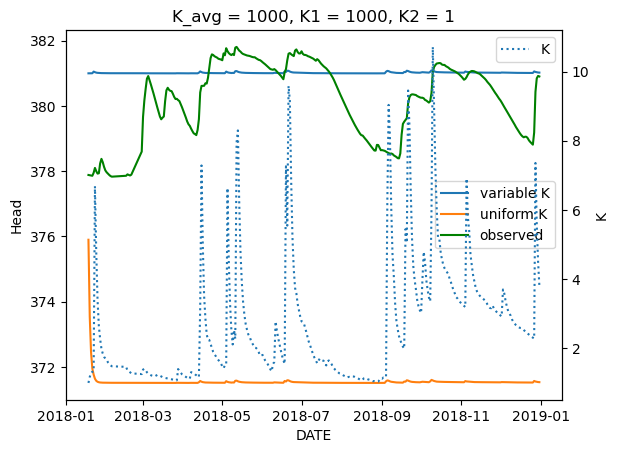

In [340]:
fig, ax = plt.subplots()
twin =ax.twinx()
sns.lineplot(out_vark, x = dates, y = 'head', label = 'variable K', ax = ax)
sns.lineplot(out, x = dates, y = 'head', label = 'uniform K', ax = ax)
ax.set_ylabel("Head")
sns.lineplot(h, x = h.index, y ='gw_elev[m]', label = 'observed', ax = ax, color = 'green')
sns.lineplot(out_vark, x = dates, y = 'K', linestyle = ':', label = 'K', ax = twin)
plt.title(f"K_avg = {kbar}, K1 = {K1}, K2 = {K2}")



<Axes: xlabel='DATE', ylabel='K'>

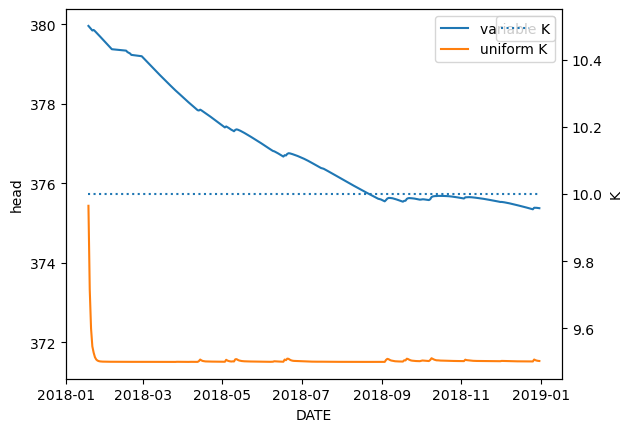

In [294]:
fig, ax = plt.subplots()
twin = ax.twinx()
sns.lineplot(out_vark, x = dates, y = 'head', label = 'variable K',ax = ax)
sns.lineplot(out, x = dates, y = 'head', label = 'uniform K',ax = ax)
sns.lineplot(out_vark, x = dates, y = 'K', linestyle = ':', label = 'K', ax = twin)


Text(0.5, 1.0, 'K_avg = 1000, K1 = 1000, K2 = 1')

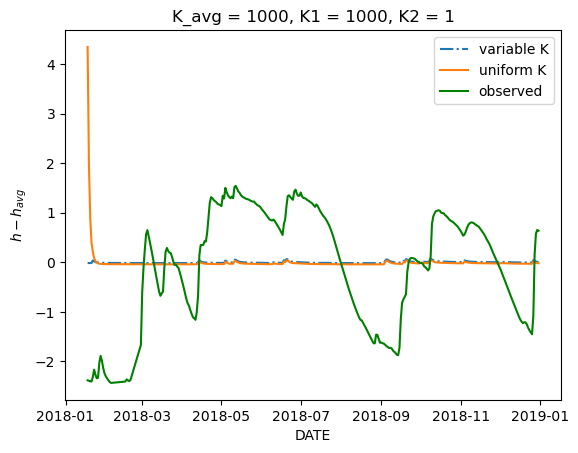

In [341]:
sns.lineplot(out_vark, x = dates, y = out_vark['head'] - out_vark['head'].mean(), label = 'variable K', linestyle= '-.')
sns.lineplot(out, x = dates, y = out['head'] - out['head'].mean(), label = 'uniform K',)
sns.lineplot(h, x = h.index, y =h['gw_elev[m]'] - h['gw_elev[m]'].mean(), label = 'observed', color = 'green')
plt.ylabel(r"$h - h_{avg}$")
plt.title(f"K_avg = {kbar}, K1 = {K1}, K2 = {K2}")


Text(0.5, 1.0, 'Effective K, K1 = 500, K2 = 1, hk = 381')

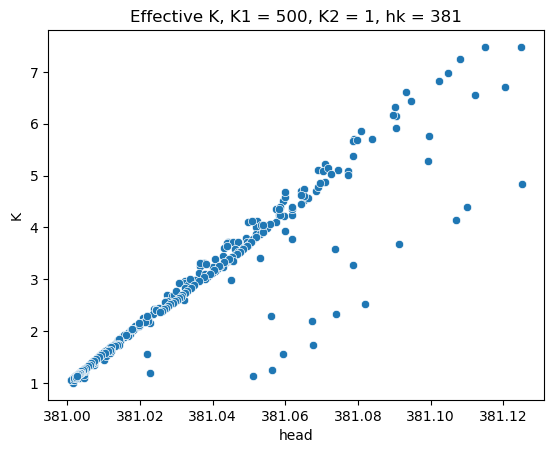

In [386]:
sns.scatterplot(out_vark, x = 'head', y ='K')
plt.title(f"Effective K, K1 = {K1}, K2 = {K2}, hk = {hk}")

In [6]:
k1 = 100
k2 = 5
hk = 381.5
Ks = varKmodel.optimize_K_2layer_by_timestep(k1, k2, hk, Q[Q.index.isin(h.index)]['Q [m3/day]'], h['gw_elev[m]'],r['RCH[m/day]'], verbose = True)

2018-01-19 00:00:00
-339.2285963308317 1330.8567052342046
1373.4102120034745
-339.2285963308317 1330.8567052342046
1373.4102120034745
-339.22859633083164 1330.8567139210563
1373.4102204211742
-339.2285963308317 1330.8567052342046
1373.4102120034745
-339.2285936634487 603.7802768405917
692.5508367337251
-339.2285936634487 603.7802768405917
692.5508367337251
-339.2285936634488 603.7802826952694
692.5508418379554
-339.2285936634487 603.7802768405917
692.5508367337251
-339.2285484158951 37.93190867914688
341.34269840791734
-339.2285484158951 37.93190867914688
341.34269840791734
-339.22854841589555 37.931910171007445
341.3426985737017
-339.2285484158951 37.93190867914688
341.34269840791734
-339.22854603140377 30.595732339964215
340.60549801786664
-339.22854603140377 30.595732339964215
340.60549801786664
-339.2285460314042 30.59573368536443
340.605498138721
-339.22854603140377 30.595732339964215
340.60549801786664
-339.22853933849973 14.621200099801495
339.5434896947525
-339.22853933849973 1

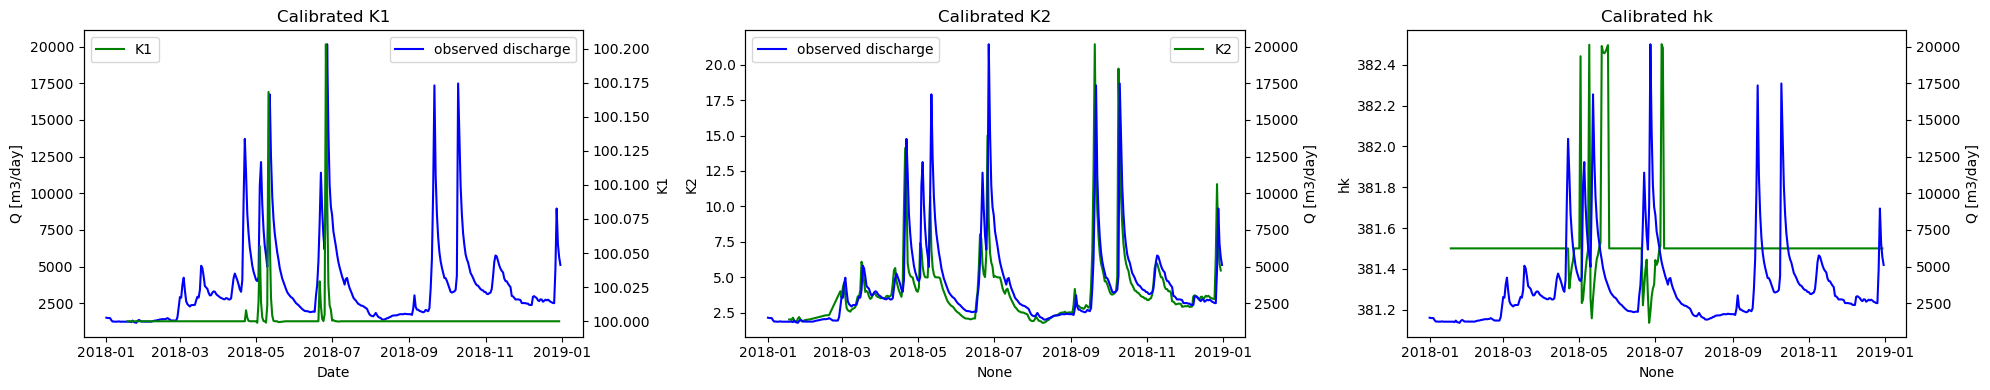

In [388]:
fig, ax = plt.subplots(1,3, figsize = (20,4))
twin = ax[0].twinx()
sns.lineplot(Ks, x = Ks.index, y = 'K1', label = 'K1', ax = twin, color = 'green')
twin.legend(loc = 'upper left')
sns.lineplot(Q, x = Q.index, y = 'Q [m3/day]', ax = ax[0], color = 'blue', label = 'observed discharge')
ax[0].set_title("Calibrated K1")
twin = ax[1].twinx()
sns.lineplot(Ks, x = Ks.index, y = 'K2',ax = ax[1], color = 'green', label = 'K2')
sns.lineplot(Q, x = Q.index, y = 'Q [m3/day]', ax = twin, color = 'blue', label = 'observed discharge')
twin.legend(loc = 'upper left')
ax[1].set_title("Calibrated K2")

twin = ax[2].twinx()
sns.lineplot(Ks, x = Ks.index, y = 'hk',ax = ax[2], color = 'green')
sns.lineplot(Q, x = Q.index, y = 'Q [m3/day]', ax = twin, color = 'blue')
ax[2].set_title("Calibrated hk")


plt.tight_layout()

In [7]:
Ks_h = Ks.join(h) 


In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (12,4))
# sns.scatterplot(Ks_h, x = 'gw_elev[m]', y = 'K1')
sns.scatterplot(Ks_h, x = 'gw_elev[m]', y = 'K2', ax = ax[1], color = 'pink', label = 'K2', legend = False)
sns.scatterplot(Ks_h, x = 'gw_elev[m]', y = 'K1', ax = ax[0], color = 'teal', label = 'K1', legend = False)
sns.scatterplot(Ks_h, x = 'gw_elev[m]', y = 'hk', ax = ax[2], color = 'purple', label = 'hk', legend = False)
sns.lineplot(x = np.arange(377, 383, 1), y =np.arange(377, 383, 1), ax = ax[2], label = 'hk = h')
ax[2].set_xlim(378, 382)
ax[2].set_ylim(378, 383)

plt.suptitle(rf'Calibrated K1, K2, hk. $K_1^o$ = {k1}, $K_2^o$ = {k2}, $h_k^o$ = {hk}')
plt.tight_layout()


In [185]:
Ks_h['K_eff'] = Ks_h['K1'] * np.maximum(Ks_h['gw_elev[m]'] - Ks_h['hk'], 0)/(Ks_h['gw_elev[m]']-hs) + Ks_h['K2']*(Ks_h['hk'] - hs)/(Ks_h['gw_elev[m]']-hs)

In [188]:
Ks_h['is_K_eff'] = Ks_h['gw_elev[m]'] > Ks_h['hk']

In [390]:
results = pd.DataFrame(columns = ['h', 'Q', 'K'])
for date in Ks_h.index:
    ht = Ks_h.loc[date, 'gw_elev[m]']
    rt = r.loc[date, 'RCH[m/day]']
    K1 = Ks_h.loc[date, 'K1']
    h_pred, Q_pred, K = varKmodel.explicit_solve(ht, rt, dt, True, K1 = K1)
    results.loc[date] = [h_pred, Q_pred, K]

k: 1
k = 1, qs: 638.4944000000019, qin: 1253.4474899999998, h: 377.8882501994086
k: 1
k = 1, qs: 637.5800000000027, qin: 1330.3863899999997, h: 377.87952476553767
k: 1
k = 1, qs: 636.6655999999978, qin: 1277.1699299999998, h: 377.87009957166663
k: 1
k = 1, qs: 636.0560000000021, qin: 1279.8948299999997, h: 377.86402149908605
k: 1
k = 1, qs: 645.1999999999997, qin: 10791.91809, h: 378.0065522477957
k: 1
k = 1, qs: 660.135200000002, qin: 2980.2993899999997, h: 378.11382600102155
k: 1
k = 1, qs: 650.0767999999993, qin: 2092.33632, h: 378.0085220834409
k: 1
k = 1, qs: 642.7616, qin: 1906.6804199999997, h: 377.93441126247313
k: 1
k = 1, qs: 643.6759999999992, qin: 1847.8709399999996, h: 377.9432341663441
k: 1
k = 1, qs: 673.8512000000014, qin: 1656.6052799999998, h: 378.24379562408603
k: 1
k = 1, qs: 687.8719999999987, qin: 1648.3664099999999, h: 378.3838839484408
k: 1
k = 1, qs: 677.8136000000018, qin: 1591.0719, h: 378.2830459908602
k: 1
k = 1, qs: 663.488000000001, qin: 1578.28533, h: 37

In [8]:
results = pd.DataFrame(columns = ['h', 'Q', 'K'])
for date in Ks_h.index:
    ht = Ks_h.loc[date, 'gw_elev[m]']
    rt = r.loc[date, 'RCH[m/day]']
    K1 = Ks_h.loc[date, 'K1']
    K2 = Ks_h.loc[date, 'K2']
    hk = Ks_h.loc[date, 'hk']
    h_pred, Q_pred, K = varKmodel.explicit_solve(ht, rt, dt, True, K1 = K1, K2 = K2, hk = hk)
    results.loc[date] = [h_pred, Q_pred, K]

k: 2.0307848320860558
k = 2.0307848320860558, qs: 1296.6447428918905, qin: 1253.4474899999998, h: 377.8847117567049
k: 2.036136756924405
k = 2.036136756924405, qs: 1298.2000734798673, qin: 1330.3863899999997, h: 377.8759730447125
k: 1.9942563534045574
k = 1.9942563534045574, qs: 1269.67441779412, qin: 1277.1699299999998, h: 377.8666962984527
k: 2.1593012373403755
k = 2.1593012373403755, qs: 1373.4365078177743, qin: 1279.8948299999997, h: 377.8600570877537
k: 1.971915359441827
k = 1.971915359441827, qs: 1272.2797899118664, qin: 10791.91809, h: 378.00318085107574
k: 1.8858752365097065
k = 1.8858752365097065, qs: 1244.9326264283861, qin: 2980.2993899999997, h: 378.1106819288364
k: 1.881008356121665
k = 1.881008356121665, qs: 1222.799892920831, qin: 2092.33632, h: 378.0054429270273
k: 2.101517694391847
k = 2.101517694391847, qs: 1350.7748756756146, qin: 1906.6804199999997, h: 377.9306047394856
k: 2.200288130157658
k = 2.200288130157658, qs: 1416.272662467359, qin: 1847.8709399999996, h: 37

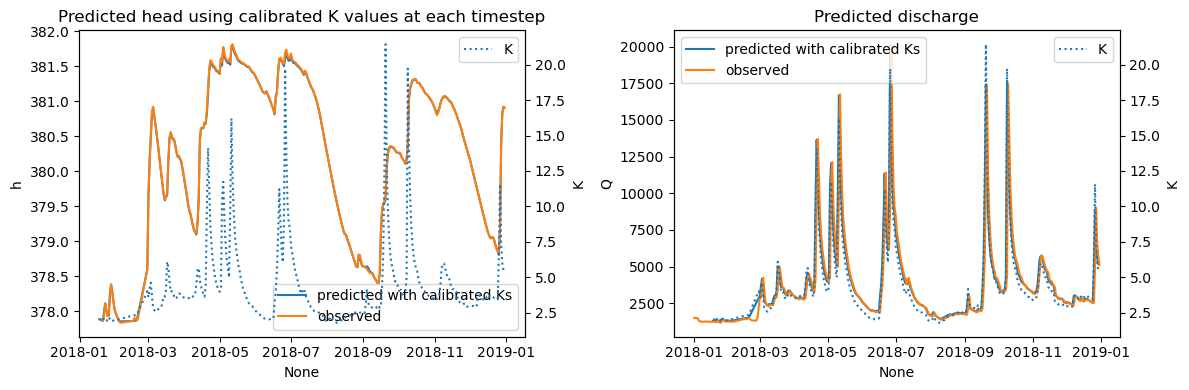

In [400]:
fig, ax = plt.subplots(1, 2,figsize = (12, 4))
sns.lineplot(results, x=results.index, y='h',ax=ax[0], label = 'predicted with calibrated Ks')
sns.lineplot(h, x = h.index, y = 'gw_elev[m]', ax = ax[0], label = 'observed')
ax[0].legend(loc = 'best')
sns.lineplot(results, x= results.index, y = 'K', ax = ax[0].twinx(), label = 'K', linestyle = ':')
ax[0].set_title("Predicted head using calibrated K values at each timestep")
sns.lineplot(results, x=results.index, y='Q',ax=ax[1], label = 'predicted with calibrated Ks')
sns.lineplot(Q, x = Q.index, y = 'Q [m3/day]', ax = ax[1], label = 'observed')
ax[1].legend(loc = 'best')
sns.lineplot(results, x= results.index, y = 'K', ax = ax[1].twinx(), label = 'K', linestyle = ':')
ax[1].set_title("Predicted discharge")
plt.tight_layout()


<Axes: xlabel='Q', ylabel='K'>

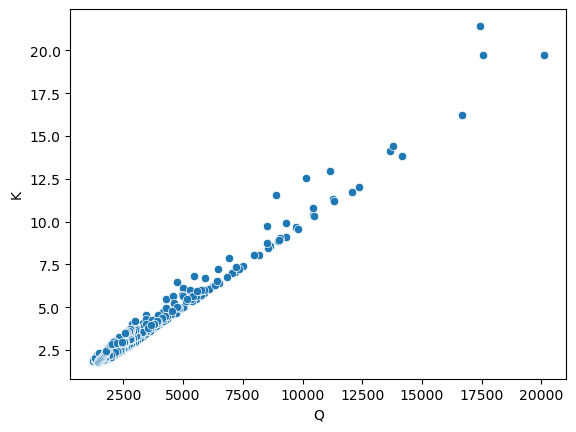

In [11]:
sns.scatterplot(results, x = 'Q', y = 'K')


Text(0.5, 1.0, 'Effective Calibrated K')

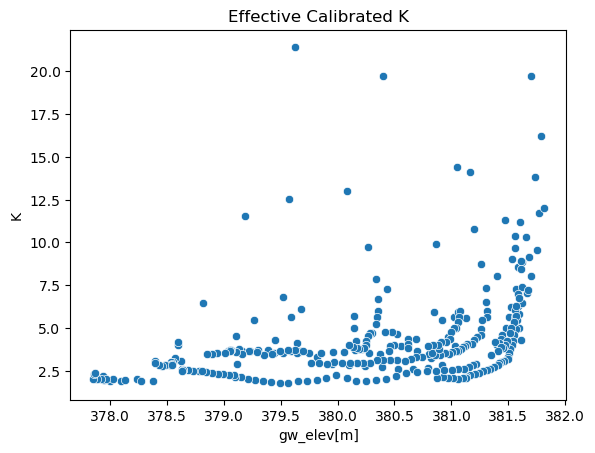

In [398]:
sns.scatterplot(results, x = Ks_h['gw_elev[m]'], y = 'K')
plt.title("Effective Calibrated K")

## Parametrized K

In [2]:
importlib.reload(lumped_parameter_model)
from lumped_parameter_model import *

A = 1.86e6 #m2
w = np.sqrt(A)
l = np.sqrt(A)
hk = 381
K1 = 500
kbar = K1 #m/d
b = 50
hs = 371.5 #m
sy = 0.1
dt = 1. 

model = Model(w =w, kbar = kbar, l = l, hs=hs, b=b, sy=sy, dt= dt)

In [6]:
rech = r[r.index.isin(h.index)]['RCH[m/day]']
n = len(rech)
h_o = h.loc[rech.index[0]]['gw_elev[m]']
q_o = Q.loc[rech.index[0]]['Q [m3/day]']

In [10]:
cal_Ks = model.optimize_K_by_timestep(100, Q, h['gw_elev[m]'], rech, weight_Q = 0.8, weight_h = 0.2, verbose = True)

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.1329789146596 Q [m3/day]    1.382718e+06
dtype: float64
Q [m3/day]    1.236741e+06
dtype: float64
-339.13297891463947 Q [m3/day]    1.382718e+06
dtype: float64
Q [m3/day]    1.236741e+06
dtype: float64
-339.13497355597565 Q [m3/day]    1.354663e+06
dtype: float64
Q [m3/day]    1.211647e+06
dtype: float64
-339.13497355595587 Q [m3/day]    1.354663e+06
dtype: float64
Q [m3/day]    1.211647e+06
dtype: float64
-339.14274187821917 Q [m3/day]    1.245316e+06
dtype: float64
Q [m3/day]    1.113844e+06
dtype: float64
-339.14274187820024 Q [m3/day]    1.245316e+06
dtype: float64
Q [m3/day]    1.113844e+06
dtype: float64
-339.170451278858 Q [m3/day]    853935.609196
dtype: float64
Q [m3/day]    763783.243289
dtype: float64
-339.1704512788424 Q [m3/day]    853935.609417
dtype: float64
Q [m3/day]    763783.243487
dtype: float64
-339.22852146097574 Q [m3/day]   -1.290639
dtype: float64
Q [m3/day]    151.711999
dtype: float64
-339.2285214609763 Q [m3/day]   -1.290639
dtype: float64
Q [m3/day]   

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.2231474142006 Q [m3/day]   -1.290638
dtype: float64
Q [m3/day]    151.709595
dtype: float64
-339.2231474142054 Q [m3/day]   -1.290638
dtype: float64
Q [m3/day]    151.709595
dtype: float64
-339.2231472642208 Q [m3/day]   -1.290567
dtype: float64
Q [m3/day]    151.709595
dtype: float64
-339.2231472642257 Q [m3/day]   -1.290567
dtype: float64
Q [m3/day]    151.709595
dtype: float64
-339.2231466642812 Q [m3/day]   -1.289999
dtype: float64
Q [m3/day]    151.709591
dtype: float64
-339.2231466642861 Q [m3/day]   -1.289999
dtype: float64
Q [m3/day]    151.709591
dtype: float64
-339.2231442641927 Q [m3/day]   -1.283212
dtype: float64
Q [m3/day]    151.709544
dtype: float64
-339.2231442641975 Q [m3/day]   -1.283212
dtype: float64
Q [m3/day]    151.709544
dtype: float64
-339.22313465855586 Q [m3/day]   -1.183813
dtype: float64
Q [m3/day]    151.708893
dtype: float64
-339.22313465856075 Q [m3/day]   -1.183813
dtype: float64
Q [m3/day]    151.708893
dtype: float64
-339.2230961514882 Q [m3/day

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.2116022329442 Q [m3/day]   -0.010795
dtype: float64
Q [m3/day]    151.700041
dtype: float64
Q metrics: std = Q [m3/day]    2835.486656
dtype: float64, mean = Q [m3/day]    3659.752211
dtype: float64
h metrics: std = 1.1209770057044761, mean = 380.26745780487806
-339.16811802806126 Q [m3/day]    1.608852e+06
dtype: float64
Q [m3/day]    1.439001e+06
dtype: float64
-339.1681180280441 Q [m3/day]    1.608852e+06
dtype: float64
Q [m3/day]    1.439001e+06
dtype: float64
-339.1698238596714 Q [m3/day]    1.576248e+06
dtype: float64
Q [m3/day]    1.409839e+06
dtype: float64
-339.16982385965446 Q [m3/day]    1.576248e+06
dtype: float64
Q [m3/day]    1.409839e+06
dtype: float64
-339.1764031676606 Q [m3/day]    1.449171e+06
dtype: float64
Q [m3/day]    1.296178e+06
dtype: float64
-339.17640316764465 Q [m3/day]    1.449171e+06
dtype: float64
Q [m3/day]    1.296178e+06
dtype: float64
-339.19881610439563 Q [m3/day]    994263.989847
dtype: float64
Q [m3/day]    889296.760489
dtype: float64
-339.1

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.1563990991959 Q [m3/day]    1.445115e+06
dtype: float64
Q [m3/day]    1.292550e+06
dtype: float64
-339.1563990991781 Q [m3/day]    1.445115e+06
dtype: float64
Q [m3/day]    1.292550e+06
dtype: float64
-339.1581687516141 Q [m3/day]    1.415804e+06
dtype: float64
Q [m3/day]    1.266333e+06
dtype: float64
-339.1581687515964 Q [m3/day]    1.415804e+06
dtype: float64
Q [m3/day]    1.266333e+06
dtype: float64
-339.1650277833655 Q [m3/day]    1.301561e+06
dtype: float64
Q [m3/day]    1.164151e+06
dtype: float64
-339.1650277833488 Q [m3/day]    1.301561e+06
dtype: float64
Q [m3/day]    1.164151e+06
dtype: float64
-339.1889506636363 Q [m3/day]    892639.327654
dtype: float64
Q [m3/day]    798400.900819
dtype: float64
-339.18895066362313 Q [m3/day]    892639.327885
dtype: float64
Q [m3/day]    798400.901026
dtype: float64
-339.2254220080855 Q [m3/day]   -1.290692
dtype: float64
Q [m3/day]    151.710613
dtype: float64
-339.22542200808925 Q [m3/day]   -1.290692
dtype: float64
Q [m3/day]    15

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.1471081939337 Q [m3/day]    1.382576e+06
dtype: float64
Q [m3/day]    1.236613e+06
dtype: float64
-339.14710819391524 Q [m3/day]    1.382576e+06
dtype: float64
Q [m3/day]    1.236613e+06
dtype: float64
-339.14894876901866 Q [m3/day]    1.354522e+06
dtype: float64
Q [m3/day]    1.211521e+06
dtype: float64
-339.14894876900036 Q [m3/day]    1.354522e+06
dtype: float64
Q [m3/day]    1.211521e+06
dtype: float64
-339.1561008263374 Q [m3/day]    1.245180e+06
dtype: float64
Q [m3/day]    1.113723e+06
dtype: float64
-339.15610082631997 Q [m3/day]    1.245180e+06
dtype: float64
Q [m3/day]    1.113723e+06
dtype: float64
-339.1813451672771 Q [m3/day]    853823.493047
dtype: float64
Q [m3/day]    763682.96356
dtype: float64
-339.181345167263 Q [m3/day]    853823.493269
dtype: float64
Q [m3/day]    763682.963759
dtype: float64
-339.22754291094134 Q [m3/day]   -1.290672
dtype: float64
Q [m3/day]    151.711561
dtype: float64
-339.2275429109434 Q [m3/day]   -1.290672
dtype: float64
Q [m3/day]    1

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.227995949899 Q [m3/day]   -0.262246
dtype: float64
Q [m3/day]    151.707553
dtype: float64
-339.22799594989743 Q [m3/day]   -0.262246
dtype: float64
Q [m3/day]    151.707553
dtype: float64
-339.2279942297054 Q [m3/day]    0.017335
dtype: float64
Q [m3/day]    151.707372
dtype: float64
-339.22799422970377 Q [m3/day]    0.017335
dtype: float64
Q [m3/day]    151.707372
dtype: float64
-339.22799434560125 Q [m3/day]   -0.002543
dtype: float64
Q [m3/day]    151.707371
dtype: float64
-339.22799434559965 Q [m3/day]   -0.002543
dtype: float64
Q [m3/day]    151.707371
dtype: float64
-339.2279617680402 Q [m3/day]    11.347273
dtype: float64
Q [m3/day]    152.046475
dtype: float64
-339.2279617680386 Q [m3/day]    11.347274
dtype: float64
Q [m3/day]    152.046475
dtype: float64
-339.2279939823341 Q [m3/day]    0.060266
dtype: float64
Q [m3/day]    151.70738
dtype: float64
-339.2279939823325 Q [m3/day]    0.060266
dtype: float64
Q [m3/day]    151.70738
dtype: float64
-339.2279943279306 Q [m3/da

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.106681141412 Q [m3/day]    0.033418
dtype: float64
Q [m3/day]    151.653121
dtype: float64
-339.1066768766229 Q [m3/day]   -0.01805
dtype: float64
Q [m3/day]    151.653117
dtype: float64
-339.10667687659225 Q [m3/day]   -0.01805
dtype: float64
Q [m3/day]    151.653117
dtype: float64
-339.10667689040065 Q [m3/day]   -0.017885
dtype: float64
Q [m3/day]    151.653117
dtype: float64
-339.1066768903699 Q [m3/day]   -0.017886
dtype: float64
Q [m3/day]    151.653117
dtype: float64
-339.10667694551137 Q [m3/day]   -0.017227
dtype: float64
Q [m3/day]    151.653117
dtype: float64
-339.1066769454806 Q [m3/day]   -0.017227
dtype: float64
Q [m3/day]    151.653117
dtype: float64
-339.1066771659541 Q [m3/day]   -0.014591
dtype: float64
Q [m3/day]    151.653117
dtype: float64
-339.10667716592343 Q [m3/day]   -0.014591
dtype: float64
Q [m3/day]    151.653117
dtype: float64
Q metrics: std = Q [m3/day]    2835.486656
dtype: float64, mean = Q [m3/day]    3659.752211
dtype: float64
h metrics: std = 1.

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.21692798679345 Q [m3/day]   -0.007783
dtype: float64
Q [m3/day]    151.702422
dtype: float64
-339.21692772721957 Q [m3/day]    0.002302
dtype: float64
Q [m3/day]    151.702422
dtype: float64
-339.21692772722986 Q [m3/day]    0.002302
dtype: float64
Q [m3/day]    151.702422
dtype: float64
-339.21692864976234 Q [m3/day]   -0.033362
dtype: float64
Q [m3/day]    151.702425
dtype: float64
-339.2169286497727 Q [m3/day]   -0.033362
dtype: float64
Q [m3/day]    151.702425
dtype: float64
-339.2169277306558 Q [m3/day]    0.002168
dtype: float64
Q [m3/day]    151.702422
dtype: float64
-339.21692773066616 Q [m3/day]    0.002168
dtype: float64
Q [m3/day]    151.702422
dtype: float64
Q metrics: std = Q [m3/day]    2835.486656
dtype: float64, mean = Q [m3/day]    3659.752211
dtype: float64
h metrics: std = 1.1209770057044761, mean = 380.26745780487806
-339.11133761598927 Q [m3/day]    2.890088e+06
dtype: float64
Q [m3/day]    2.584973e+06
dtype: float64
-339.1113376159569 Q [m3/day]    2.890088e

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.13840424909455 Q [m3/day]    2.589182e+06
dtype: float64
Q [m3/day]    2.315834e+06
dtype: float64
-339.13840424906743 Q [m3/day]    2.589182e+06
dtype: float64
Q [m3/day]    2.315834e+06
dtype: float64
-339.148928104754 Q [m3/day]    2.378650e+06
dtype: float64
Q [m3/day]    2.127529e+06
dtype: float64
-339.1489281047285 Q [m3/day]    2.378650e+06
dtype: float64
Q [m3/day]    2.127529e+06
dtype: float64
-339.18449721698624 Q [m3/day]    1.625785e+06
dtype: float64
Q [m3/day]    1.454146e+06
dtype: float64
-339.18449721696726 Q [m3/day]    1.625785e+06
dtype: float64
Q [m3/day]    1.454146e+06
dtype: float64
-339.2104347265815 Q [m3/day]   -1.290644
dtype: float64
Q [m3/day]    151.70391
dtype: float64
-339.2104347265937 Q [m3/day]   -1.290644
dtype: float64
Q [m3/day]    151.70391
dtype: float64
-339.21043472926476 Q [m3/day]   -1.290644
dtype: float64
Q [m3/day]    151.70391
dtype: float64
-339.2104347292769 Q [m3/day]   -1.290644
dtype: float64
Q [m3/day]    151.70391
dtype: fl

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.21405833101056 Q [m3/day]   -0.367235
dtype: float64
Q [m3/day]    151.701494
dtype: float64
-339.2140456499035 Q [m3/day]    0.044243
dtype: float64
Q [m3/day]    151.701138
dtype: float64
-339.2140456499138 Q [m3/day]    0.044242
dtype: float64
Q [m3/day]    151.701138
dtype: float64
-339.2140471678777 Q [m3/day]   -0.008986
dtype: float64
Q [m3/day]    151.701134
dtype: float64
-339.21404716788805 Q [m3/day]   -0.008986
dtype: float64
Q [m3/day]    151.701134
dtype: float64
-339.214047162897 Q [m3/day]   -0.008813
dtype: float64
Q [m3/day]    151.701134
dtype: float64
-339.2140471629073 Q [m3/day]   -0.008813
dtype: float64
Q [m3/day]    151.701134
dtype: float64
-339.2140471429738 Q [m3/day]   -0.008121
dtype: float64
Q [m3/day]    151.701134
dtype: float64
-339.2140471429842 Q [m3/day]   -0.008122
dtype: float64
Q [m3/day]    151.701134
dtype: float64
-339.2140470632813 Q [m3/day]   -0.005353
dtype: float64
Q [m3/day]    151.701134
dtype: float64
-339.2140470632917 Q [m3/day]

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-338.50083442398744 Q [m3/day]    2.075837e+06
dtype: float64
Q [m3/day]    1.856685e+06
dtype: float64
-338.5008344239166 Q [m3/day]    2.075837e+06
dtype: float64
Q [m3/day]    1.856685e+06
dtype: float64
-338.50790180469835 Q [m3/day]    2.031822e+06
dtype: float64
Q [m3/day]    1.817317e+06
dtype: float64
-338.5079018046279 Q [m3/day]    2.031822e+06
dtype: float64
Q [m3/day]    1.817317e+06
dtype: float64
-338.53582649103 Q [m3/day]    1.860481e+06
dtype: float64
Q [m3/day]    1.664065e+06
dtype: float64
-338.53582649096086 Q [m3/day]    1.860481e+06
dtype: float64
Q [m3/day]    1.664065e+06
dtype: float64
-338.64200785215945 Q [m3/day]    1.250577e+06
dtype: float64
Q [m3/day]    1.118550e+06
dtype: float64
-338.64200785209596 Q [m3/day]    1.250577e+06
dtype: float64
Q [m3/day]    1.118550e+06
dtype: float64
-339.0137583191293 Q [m3/day]   -1.290694
dtype: float64
Q [m3/day]    151.615957
dtype: float64
-339.01375831909075 Q [m3/day]   -1.290694
dtype: float64
Q [m3/day]    151.

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.22018314227785 Q [m3/day]    0.039152
dtype: float64
Q [m3/day]    151.703882
dtype: float64
-339.2201831422695 Q [m3/day]    0.039153
dtype: float64
Q [m3/day]    151.703882
dtype: float64
-339.22018408638445 Q [m3/day]   -0.00438
dtype: float64
Q [m3/day]    151.703878
dtype: float64
-339.22018408637615 Q [m3/day]   -0.00438
dtype: float64
Q [m3/day]    151.703878
dtype: float64
-339.2201099394927 Q [m3/day]    5.603203
dtype: float64
Q [m3/day]    151.786605
dtype: float64
-339.2201099394843 Q [m3/day]    5.603204
dtype: float64
Q [m3/day]    151.786605
dtype: float64
-339.2201839441208 Q [m3/day]    0.002133
dtype: float64
Q [m3/day]    151.703878
dtype: float64
-339.2201839441124 Q [m3/day]    0.002134
dtype: float64
Q [m3/day]    151.703878
dtype: float64
Q metrics: std = Q [m3/day]    2835.486656
dtype: float64, mean = Q [m3/day]    3659.752211
dtype: float64
h metrics: std = 1.1209770057044761, mean = 380.26745780487806
-339.0709710147468 Q [m3/day]    2.664199e+06
dtype: 

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.22414454282625 Q [m3/day]   -1.290552
dtype: float64
Q [m3/day]    151.710041
dtype: float64
-339.22414454283233 Q [m3/day]   -1.290552
dtype: float64
Q [m3/day]    151.710041
dtype: float64
-339.22414350925345 Q [m3/day]   -1.289043
dtype: float64
Q [m3/day]    151.71003
dtype: float64
-339.2241435092595 Q [m3/day]   -1.289043
dtype: float64
Q [m3/day]    151.71003
dtype: float64
-339.2241393737629 Q [m3/day]   -1.266604
dtype: float64
Q [m3/day]    151.709877
dtype: float64
-339.22413937376894 Q [m3/day]   -1.266604
dtype: float64
Q [m3/day]    151.709877
dtype: float64
-339.22412281261205 Q [m3/day]   -0.914405
dtype: float64
Q [m3/day]    151.707844
dtype: float64
-339.22412281261813 Q [m3/day]   -0.914405
dtype: float64
Q [m3/day]    151.707844
dtype: float64
-339.2240562609901 Q [m3/day]    4.693524
dtype: float64
Q [m3/day]    151.763683
dtype: float64
-339.22405626099624 Q [m3/day]    4.693523
dtype: float64
Q [m3/day]    151.763683
dtype: float64
-339.2241091769318 Q [m3/

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.228300196574 Q [m3/day]    0.000878
dtype: float64
Q [m3/day]    151.707508
dtype: float64
-339.2283001965725 Q [m3/day]    0.000878
dtype: float64
Q [m3/day]    151.707508
dtype: float64
-339.22830200829424 Q [m3/day]   -0.403369
dtype: float64
Q [m3/day]    151.707938
dtype: float64
-339.2283020082927 Q [m3/day]   -0.403369
dtype: float64
Q [m3/day]    151.707938
dtype: float64
-339.2283001987311 Q [m3/day]    0.000352
dtype: float64
Q [m3/day]    151.707508
dtype: float64
-339.22830019872964 Q [m3/day]    0.000352
dtype: float64
Q [m3/day]    151.707508
dtype: float64
Q metrics: std = Q [m3/day]    2835.486656
dtype: float64, mean = Q [m3/day]    3659.752211
dtype: float64
h metrics: std = 1.1209770057044761, mean = 380.26745780487806
-339.07079141772664 Q [m3/day]    2.482229e+06
dtype: float64
Q [m3/day]    2.220173e+06
dtype: float64
-339.0707914176915 Q [m3/day]    2.482229e+06
dtype: float64
Q [m3/day]    2.220173e+06
dtype: float64
-339.0742897090151 Q [m3/day]    2.43089

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.2227121671231 Q [m3/day]   -0.74881
dtype: float64
Q [m3/day]    151.706487
dtype: float64
-339.22269565869965 Q [m3/day]   -0.0053
dtype: float64
Q [m3/day]    151.705001
dtype: float64
-339.22269565870636 Q [m3/day]   -0.0053
dtype: float64
Q [m3/day]    151.705001
dtype: float64
-339.22254138791305 Q [m3/day]    21.970503
dtype: float64
Q [m3/day]    152.97238
dtype: float64
-339.2225413879199 Q [m3/day]    21.970502
dtype: float64
Q [m3/day]    152.972379
dtype: float64
-339.22268619992815 Q [m3/day]    0.562518
dtype: float64
Q [m3/day]    151.705831
dtype: float64
-339.2226861999349 Q [m3/day]    0.562517
dtype: float64
Q [m3/day]    151.705831
dtype: float64
-339.22269554356586 Q [m3/day]    0.000992
dtype: float64
Q [m3/day]    151.705001
dtype: float64
-339.2226955435726 Q [m3/day]    0.000991
dtype: float64
Q [m3/day]    151.705001
dtype: float64
Q metrics: std = Q [m3/day]    2835.486656
dtype: float64, mean = Q [m3/day]    3659.752211
dtype: float64
h metrics: std = 1.

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.2196331855808 Q [m3/day]   -1.290613
dtype: float64
Q [m3/day]    151.708024
dtype: float64
-339.2196331855887 Q [m3/day]   -1.290613
dtype: float64
Q [m3/day]    151.708024
dtype: float64
-339.21963319713217 Q [m3/day]   -1.290608
dtype: float64
Q [m3/day]    151.708024
dtype: float64
-339.2196331971401 Q [m3/day]   -1.290608
dtype: float64
Q [m3/day]    151.708024
dtype: float64
-339.21963324333785 Q [m3/day]   -1.290591
dtype: float64
Q [m3/day]    151.708024
dtype: float64
-339.21963324334575 Q [m3/day]   -1.290591
dtype: float64
Q [m3/day]    151.708024
dtype: float64
-339.2196334281592 Q [m3/day]   -1.290503
dtype: float64
Q [m3/day]    151.708023
dtype: float64
-339.2196334281671 Q [m3/day]   -1.290503
dtype: float64
Q [m3/day]    151.708023
dtype: float64
-339.2196341674257 Q [m3/day]   -1.289894
dtype: float64
Q [m3/day]    151.708019
dtype: float64
-339.2196341674336 Q [m3/day]   -1.289894
dtype: float64
Q [m3/day]    151.708019
dtype: float64
-339.2196371241867 Q [m3/da

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.13065558161026 Q [m3/day]    2.040304e+06
dtype: float64
Q [m3/day]    1.824904e+06
dtype: float64
-339.13065558158513 Q [m3/day]    2.040304e+06
dtype: float64
Q [m3/day]    1.824904e+06
dtype: float64
-339.13314746468217 Q [m3/day]    1.998191e+06
dtype: float64
Q [m3/day]    1.787236e+06
dtype: float64
-339.13314746465744 Q [m3/day]    1.998191e+06
dtype: float64
Q [m3/day]    1.787236e+06
dtype: float64
-339.1427939019102 Q [m3/day]    1.834130e+06
dtype: float64
Q [m3/day]    1.640496e+06
dtype: float64
-339.1427939018867 Q [m3/day]    1.834130e+06
dtype: float64
Q [m3/day]    1.640496e+06
dtype: float64
-339.1762421298653 Q [m3/day]    1.248152e+06
dtype: float64
Q [m3/day]    1.116381e+06
dtype: float64
-339.17624212984697 Q [m3/day]    1.248152e+06
dtype: float64
Q [m3/day]    1.116381e+06
dtype: float64
-339.2232284001942 Q [m3/day]   -1.290695
dtype: float64
Q [m3/day]    151.709632
dtype: float64
-339.2232284002001 Q [m3/day]   -1.290695
dtype: float64
Q [m3/day]    151

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.22837486275114 Q [m3/day]   -1.290695
dtype: float64
Q [m3/day]    151.711934
dtype: float64
-339.2283748578427 Q [m3/day]   -1.290693
dtype: float64
Q [m3/day]    151.711934
dtype: float64
-339.22837485784385 Q [m3/day]   -1.290693
dtype: float64
Q [m3/day]    151.711934
dtype: float64
-339.2283748382129 Q [m3/day]   -1.290679
dtype: float64
Q [m3/day]    151.711933
dtype: float64
-339.22837483821405 Q [m3/day]   -1.290679
dtype: float64
Q [m3/day]    151.711933
dtype: float64
-339.2283747596852 Q [m3/day]   -1.290502
dtype: float64
Q [m3/day]    151.711932
dtype: float64
-339.2283747596864 Q [m3/day]   -1.290502
dtype: float64
Q [m3/day]    151.711932
dtype: float64
-339.2283744454362 Q [m3/day]   -1.287907
dtype: float64
Q [m3/day]    151.711914
dtype: float64
-339.2283744454374 Q [m3/day]   -1.287907
dtype: float64
Q [m3/day]    151.711914
dtype: float64
-339.2283731862278 Q [m3/day]   -1.247265
dtype: float64
Q [m3/day]    151.711642
dtype: float64
-339.228373186229 Q [m3/day

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-338.8480179293693 Q [m3/day]    1.151633e+06
dtype: float64
Q [m3/day]    1.030052e+06
dtype: float64
-339.1218409173397 Q [m3/day]   -1.290696
dtype: float64
Q [m3/day]    151.664291
dtype: float64
-339.1218409173139 Q [m3/day]   -1.290696
dtype: float64
Q [m3/day]    151.664291
dtype: float64
-339.121840909524 Q [m3/day]   -1.290696
dtype: float64
Q [m3/day]    151.664291
dtype: float64
-339.1218409094982 Q [m3/day]   -1.290696
dtype: float64
Q [m3/day]    151.664291
dtype: float64
-339.1218408782614 Q [m3/day]   -1.290696
dtype: float64
Q [m3/day]    151.664291
dtype: float64
-339.1218408782356 Q [m3/day]   -1.290696
dtype: float64
Q [m3/day]    151.664291
dtype: float64
-339.12184075321096 Q [m3/day]   -1.290695
dtype: float64
Q [m3/day]    151.664291
dtype: float64
-339.1218407531851 Q [m3/day]   -1.290695
dtype: float64
Q [m3/day]    151.664291
dtype: float64
-339.1218402530084 Q [m3/day]   -1.290682
dtype: float64
Q [m3/day]    151.664291
dtype: float64
-339.12184025298257 Q [m

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.22855996773336 Q [m3/day]   -1.290653
dtype: float64
Q [m3/day]    151.712016
dtype: float64
-339.22855996773274 Q [m3/day]   -1.290653
dtype: float64
Q [m3/day]    151.712016
dtype: float64
-339.2285599675629 Q [m3/day]   -1.290652
dtype: float64
Q [m3/day]    151.712016
dtype: float64
-339.2285599675624 Q [m3/day]   -1.290652
dtype: float64
Q [m3/day]    151.712016
dtype: float64
-339.22855996688133 Q [m3/day]   -1.290649
dtype: float64
Q [m3/day]    151.712016
dtype: float64
-339.22855996688077 Q [m3/day]   -1.290649
dtype: float64
Q [m3/day]    151.712016
dtype: float64
-339.2285599641549 Q [m3/day]   -1.290637
dtype: float64
Q [m3/day]    151.712016
dtype: float64
-339.2285599641544 Q [m3/day]   -1.290637
dtype: float64
Q [m3/day]    151.712016
dtype: float64
-339.22855995324835 Q [m3/day]   -1.290576
dtype: float64
Q [m3/day]    151.712015
dtype: float64
-339.22855995324784 Q [m3/day]   -1.290576
dtype: float64
Q [m3/day]    151.712015
dtype: float64
-339.22855990960636 Q [m

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.12691951707416 Q [m3/day]   -1.290437
dtype: float64
Q [m3/day]    151.666561
dtype: float64
-339.12691951704386 Q [m3/day]   -1.290437
dtype: float64
Q [m3/day]    151.666561
dtype: float64
-339.1269194037365 Q [m3/day]   -1.290416
dtype: float64
Q [m3/day]    151.666561
dtype: float64
-339.12691940370615 Q [m3/day]   -1.290416
dtype: float64
Q [m3/day]    151.666561
dtype: float64
-339.1269189503853 Q [m3/day]   -1.290321
dtype: float64
Q [m3/day]    151.66656
dtype: float64
-339.12691895035493 Q [m3/day]   -1.290321
dtype: float64
Q [m3/day]    151.66656
dtype: float64
-339.1269171369702 Q [m3/day]   -1.289802
dtype: float64
Q [m3/day]    151.666556
dtype: float64
-339.1269171369399 Q [m3/day]   -1.289802
dtype: float64
Q [m3/day]    151.666556
dtype: float64
-339.1269098831483 Q [m3/day]   -1.285518
dtype: float64
Q [m3/day]    151.666523
dtype: float64
-339.12690988311795 Q [m3/day]   -1.285518
dtype: float64
Q [m3/day]    151.666523
dtype: float64
-339.1268808652732 Q [m3/da

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.2044043859035 Q [m3/day]    6.148946
dtype: float64
Q [m3/day]    151.796486
dtype: float64
-339.20440438588776 Q [m3/day]    6.148947
dtype: float64
Q [m3/day]    151.796486
dtype: float64
-339.2045467578115 Q [m3/day]   -0.224606
dtype: float64
Q [m3/day]    151.697018
dtype: float64
-339.2045467577958 Q [m3/day]   -0.224606
dtype: float64
Q [m3/day]    151.697018
dtype: float64
-339.2045375077232 Q [m3/day]    0.015292
dtype: float64
Q [m3/day]    151.696881
dtype: float64
-339.20453750770747 Q [m3/day]    0.015292
dtype: float64
Q [m3/day]    151.696881
dtype: float64
-339.2045751489219 Q [m3/day]   -0.809203
dtype: float64
Q [m3/day]    151.698624
dtype: float64
-339.2045751489062 Q [m3/day]   -0.809202
dtype: float64
Q [m3/day]    151.698624
dtype: float64
-339.2045379721808 Q [m3/day]    0.002667
dtype: float64
Q [m3/day]    151.696881
dtype: float64
-339.20453797216504 Q [m3/day]    0.002668
dtype: float64
Q [m3/day]    151.696881
dtype: float64
-339.20453795504733 Q [m3/d

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.08935450124085 Q [m3/day]    1.896879e+06
dtype: float64
Q [m3/day]    1.696620e+06
dtype: float64
-339.08935450120293 Q [m3/day]    1.896879e+06
dtype: float64
Q [m3/day]    1.696620e+06
dtype: float64
-339.2285972383819 Q [m3/day]   -1.290538
dtype: float64
Q [m3/day]    151.712032
dtype: float64
-339.2285972383818 Q [m3/day]   -1.290538
dtype: float64
Q [m3/day]    151.712032
dtype: float64
-339.2285972383432 Q [m3/day]   -1.290535
dtype: float64
Q [m3/day]    151.712032
dtype: float64
-339.2285972383431 Q [m3/day]   -1.290535
dtype: float64
Q [m3/day]    151.712032
dtype: float64
-339.22859723818834 Q [m3/day]   -1.290525
dtype: float64
Q [m3/day]    151.712032
dtype: float64
-339.22859723818823 Q [m3/day]   -1.290525
dtype: float64
Q [m3/day]    151.712032
dtype: float64
-339.2285972375687 Q [m3/day]   -1.290483
dtype: float64
Q [m3/day]    151.712032
dtype: float64
-339.2285972375686 Q [m3/day]   -1.290483
dtype: float64
Q [m3/day]    151.712032
dtype: float64
-339.228597235

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.2285860559487 Q [m3/day]   -1.290654
dtype: float64
Q [m3/day]    151.712028
dtype: float64
-339.22858605081916 Q [m3/day]   -1.29061
dtype: float64
Q [m3/day]    151.712027
dtype: float64
-339.2285860508188 Q [m3/day]   -1.29061
dtype: float64
Q [m3/day]    151.712027
dtype: float64
-339.2285860302883 Q [m3/day]   -1.290281
dtype: float64
Q [m3/day]    151.712025
dtype: float64
-339.22858603028794 Q [m3/day]   -1.290281
dtype: float64
Q [m3/day]    151.712025
dtype: float64
-339.22858594798544 Q [m3/day]   -1.286514
dtype: float64
Q [m3/day]    151.712
dtype: float64
-339.2285859479851 Q [m3/day]   -1.286514
dtype: float64
Q [m3/day]    151.712
dtype: float64
-339.22858561590516 Q [m3/day]   -1.232208
dtype: float64
Q [m3/day]    151.711639
dtype: float64
-339.2285856159048 Q [m3/day]   -1.232208
dtype: float64
Q [m3/day]    151.711639
dtype: float64
-339.22858424168055 Q [m3/day]   -0.387153
dtype: float64
Q [m3/day]    151.70803
dtype: float64
-339.2285842416802 Q [m3/day]   -0

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.18336877953834 Q [m3/day]    0.005018
dtype: float64
Q [m3/day]    151.687414
dtype: float64
-339.18336877951697 Q [m3/day]    0.005019
dtype: float64
Q [m3/day]    151.687414
dtype: float64
-339.18336881740197 Q [m3/day]    0.004269
dtype: float64
Q [m3/day]    151.687414
dtype: float64
-339.1833688173806 Q [m3/day]    0.004269
dtype: float64
Q [m3/day]    151.687414
dtype: float64
Q metrics: std = Q [m3/day]    2835.486656
dtype: float64, mean = Q [m3/day]    3659.752211
dtype: float64
h metrics: std = 1.1209770057044761, mean = 380.26745780487806
-339.0250529586598 Q [m3/day]    3.308595e+06
dtype: float64
Q [m3/day]    2.959297e+06
dtype: float64
-339.02505295861346 Q [m3/day]    3.308595e+06
dtype: float64
Q [m3/day]    2.959297e+06
dtype: float64
-339.0296601364939 Q [m3/day]    3.239867e+06
dtype: float64
Q [m3/day]    2.897825e+06
dtype: float64
-339.0296601364481 Q [m3/day]    3.239867e+06
dtype: float64
Q [m3/day]    2.897825e+06
dtype: float64
-339.04756145140186 Q [m3/

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.22854537560465 Q [m3/day]   -0.028166
dtype: float64
Q [m3/day]    151.70762
dtype: float64
-339.2285453756054 Q [m3/day]   -0.028167
dtype: float64
Q [m3/day]    151.70762
dtype: float64
-339.2285453748706 Q [m3/day]   -0.027745
dtype: float64
Q [m3/day]    151.70762
dtype: float64
-339.2285453748713 Q [m3/day]   -0.027745
dtype: float64
Q [m3/day]    151.70762
dtype: float64
-339.2285453719342 Q [m3/day]   -0.026059
dtype: float64
Q [m3/day]    151.707619
dtype: float64
-339.22854537193496 Q [m3/day]   -0.026059
dtype: float64
Q [m3/day]    151.707619
dtype: float64
-339.22854536018804 Q [m3/day]   -0.019303
dtype: float64
Q [m3/day]    151.707618
dtype: float64
-339.2285453601888 Q [m3/day]   -0.019303
dtype: float64
Q [m3/day]    151.707618
dtype: float64
-339.2285453259134 Q [m3/day]    0.000508
dtype: float64
Q [m3/day]    151.707617
dtype: float64
-339.2285453259141 Q [m3/day]    0.000508
dtype: float64
Q [m3/day]    151.707617
dtype: float64
-339.2285453265442 Q [m3/day]  

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.2281940683032 Q [m3/day]   -0.035045
dtype: float64
Q [m3/day]    151.707464
dtype: float64
-339.22819406830524 Q [m3/day]   -0.035045
dtype: float64
Q [m3/day]    151.707464
dtype: float64
-339.22819407839387 Q [m3/day]   -0.032963
dtype: float64
Q [m3/day]    151.707463
dtype: float64
-339.228194078396 Q [m3/day]   -0.032963
dtype: float64
Q [m3/day]    151.707463
dtype: float64
-339.2281941187554 Q [m3/day]   -0.024618
dtype: float64
Q [m3/day]    151.707462
dtype: float64
-339.2281941187575 Q [m3/day]   -0.024617
dtype: float64
Q [m3/day]    151.707462
dtype: float64
-339.2281942377966 Q [m3/day]    0.000159
dtype: float64
Q [m3/day]    151.70746
dtype: float64
-339.2281942377987 Q [m3/day]    0.00016
dtype: float64
Q [m3/day]    151.70746
dtype: float64
-339.22819423500727 Q [m3/day]   -0.000424
dtype: float64
Q [m3/day]    151.70746
dtype: float64
-339.2281942350093 Q [m3/day]   -0.000424
dtype: float64
Q [m3/day]    151.70746
dtype: float64
Q metrics: std = Q [m3/day]    28

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.2274634717376 Q [m3/day]   -0.084975
dtype: float64
Q [m3/day]    151.707153
dtype: float64
-339.22746347174115 Q [m3/day]   -0.084975
dtype: float64
Q [m3/day]    151.707153
dtype: float64
-339.2274469278317 Q [m3/day]    2.721641
dtype: float64
Q [m3/day]    151.726656
dtype: float64
-339.2274469278352 Q [m3/day]    2.721641
dtype: float64
Q [m3/day]    151.726656
dtype: float64
-339.2274628868001 Q [m3/day]   -0.013425
dtype: float64
Q [m3/day]    151.707134
dtype: float64
-339.2274628868036 Q [m3/day]   -0.013425
dtype: float64
Q [m3/day]    151.707134
dtype: float64
-339.22746277331674 Q [m3/day]    0.000693
dtype: float64
Q [m3/day]    151.707133
dtype: float64
-339.2274627733203 Q [m3/day]    0.000693
dtype: float64
Q [m3/day]    151.707133
dtype: float64
Q metrics: std = Q [m3/day]    2835.486656
dtype: float64, mean = Q [m3/day]    3659.752211
dtype: float64
h metrics: std = 1.1209770057044761, mean = 380.26745780487806
-339.02873084763036 Q [m3/day]    3.034625e+06
dtype

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.00360765493383 Q [m3/day]    3.158782e+06
dtype: float64
Q [m3/day]    2.825300e+06
dtype: float64
-339.0036076548851 Q [m3/day]    3.158782e+06
dtype: float64
Q [m3/day]    2.825300e+06
dtype: float64
-339.00845717176026 Q [m3/day]    3.091576e+06
dtype: float64
Q [m3/day]    2.765190e+06
dtype: float64
-339.00845717171205 Q [m3/day]    3.091576e+06
dtype: float64
Q [m3/day]    2.765190e+06
dtype: float64
-339.02732688844776 Q [m3/day]    2.829981e+06
dtype: float64
Q [m3/day]    2.531212e+06
dtype: float64
-339.02732688840166 Q [m3/day]    2.829981e+06
dtype: float64
Q [m3/day]    2.531212e+06
dtype: float64
-339.09435214530515 Q [m3/day]    1.899219e+06
dtype: float64
Q [m3/day]    1.698713e+06
dtype: float64
-339.0943521452675 Q [m3/day]    1.899219e+06
dtype: float64
Q [m3/day]    1.698713e+06
dtype: float64
-339.22855876627887 Q [m3/day]   -1.290634
dtype: float64
Q [m3/day]    151.712015
dtype: float64
-339.2285587662795 Q [m3/day]   -1.290634
dtype: float64
Q [m3/day]    1

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-338.9984953071814 Q [m3/day]    3.209090e+06
dtype: float64
Q [m3/day]    2.870297e+06
dtype: float64
-338.9984953071325 Q [m3/day]    3.209090e+06
dtype: float64
Q [m3/day]    2.870297e+06
dtype: float64
-339.01763180961547 Q [m3/day]    2.944738e+06
dtype: float64
Q [m3/day]    2.633854e+06
dtype: float64
-339.0176318095687 Q [m3/day]    2.944738e+06
dtype: float64
Q [m3/day]    2.633854e+06
dtype: float64
-339.0858712128276 Q [m3/day]    2.000943e+06
dtype: float64
Q [m3/day]    1.789698e+06
dtype: float64
-339.08587121278913 Q [m3/day]    2.000943e+06
dtype: float64
Q [m3/day]    1.789698e+06
dtype: float64
-339.22857564259294 Q [m3/day]   -1.289737
dtype: float64
Q [m3/day]    151.712017
dtype: float64
-339.2285756425934 Q [m3/day]   -1.289737
dtype: float64
Q [m3/day]    151.712017
dtype: float64
-339.22857564199194 Q [m3/day]   -1.289722
dtype: float64
Q [m3/day]    151.712017
dtype: float64
-339.22857564199245 Q [m3/day]   -1.289722
dtype: float64
Q [m3/day]    151.712017
dtyp

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.22854278639454 Q [m3/day]    0.453755
dtype: float64
Q [m3/day]    151.708159
dtype: float64
-339.2285451389193 Q [m3/day]   -0.760946
dtype: float64
Q [m3/day]    151.709144
dtype: float64
-339.22854513891855 Q [m3/day]   -0.760945
dtype: float64
Q [m3/day]    151.709144
dtype: float64
-339.22854353722266 Q [m3/day]   -0.007147
dtype: float64
Q [m3/day]    151.707617
dtype: float64
-339.2285435372219 Q [m3/day]   -0.007147
dtype: float64
Q [m3/day]    151.707617
dtype: float64
-339.22852256070496 Q [m3/day]    34.344022
dtype: float64
Q [m3/day]    154.786329
dtype: float64
-339.22852256070405 Q [m3/day]    34.344024
dtype: float64
Q [m3/day]    154.786329
dtype: float64
-339.2285419334733 Q [m3/day]    1.05819
dtype: float64
Q [m3/day]    151.710568
dtype: float64
-339.22854193347257 Q [m3/day]    1.058191
dtype: float64
Q [m3/day]    151.710568
dtype: float64
-339.2285435259692 Q [m3/day]   -0.000739
dtype: float64
Q [m3/day]    151.707617
dtype: float64
-339.22854352596846 Q [

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.2283067796382 Q [m3/day]   -1.279963
dtype: float64
Q [m3/day]    151.71183
dtype: float64
-339.2283067796399 Q [m3/day]   -1.279963
dtype: float64
Q [m3/day]    151.71183
dtype: float64
-339.2283095649626 Q [m3/day]   -1.125662
dtype: float64
Q [m3/day]    151.710853
dtype: float64
-339.2283095649644 Q [m3/day]   -1.125662
dtype: float64
Q [m3/day]    151.710853
dtype: float64
-339.2283205723259 Q [m3/day]    1.323382
dtype: float64
Q [m3/day]    151.712135
dtype: float64
-339.2283205723276 Q [m3/day]    1.323383
dtype: float64
Q [m3/day]    151.712135
dtype: float64
-339.228315095815 Q [m3/day]   -0.267422
dtype: float64
Q [m3/day]    151.707703
dtype: float64
-339.22831509581664 Q [m3/day]   -0.267422
dtype: float64
Q [m3/day]    151.707703
dtype: float64
-339.2283163883071 Q [m3/day]    0.040739
dtype: float64
Q [m3/day]    151.707519
dtype: float64
-339.2283163883088 Q [m3/day]    0.04074
dtype: float64
Q [m3/day]    151.707519
dtype: float64
-339.22831619561737 Q [m3/day]   

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.2276789189001 Q [m3/day]    0.04126
dtype: float64
Q [m3/day]    151.707234
dtype: float64
-339.227679263813 Q [m3/day]   -0.006867
dtype: float64
Q [m3/day]    151.70723
dtype: float64
-339.227679263816 Q [m3/day]   -0.006867
dtype: float64
Q [m3/day]    151.70723
dtype: float64
-339.22764036900816 Q [m3/day]    10.830409
dtype: float64
Q [m3/day]    152.016172
dtype: float64
-339.2276403690112 Q [m3/day]    10.830408
dtype: float64
Q [m3/day]    152.016172
dtype: float64
-339.22767885636864 Q [m3/day]    0.050079
dtype: float64
Q [m3/day]    151.707237
dtype: float64
-339.2276788563717 Q [m3/day]    0.050078
dtype: float64
Q [m3/day]    151.707237
dtype: float64
-339.22767921029015 Q [m3/day]    0.000544
dtype: float64
Q [m3/day]    151.70723
dtype: float64
-339.22767921029316 Q [m3/day]    0.000543
dtype: float64
Q [m3/day]    151.70723
dtype: float64
Q metrics: std = Q [m3/day]    2835.486656
dtype: float64, mean = Q [m3/day]    3659.752211
dtype: float64
h metrics: std = 1.12

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.22768404029733 Q [m3/day]   -1.289511
dtype: float64
Q [m3/day]    151.711617
dtype: float64
-339.22768404030035 Q [m3/day]   -1.289511
dtype: float64
Q [m3/day]    151.711617
dtype: float64
-339.2276823646092 Q [m3/day]   -1.27196
dtype: float64
Q [m3/day]    151.711497
dtype: float64
-339.22768236461224 Q [m3/day]   -1.27196
dtype: float64
Q [m3/day]    151.711497
dtype: float64
-339.22767564650604 Q [m3/day]   -0.9918
dtype: float64
Q [m3/day]    151.709822
dtype: float64
-339.22767564650906 Q [m3/day]   -0.9918
dtype: float64
Q [m3/day]    151.709822
dtype: float64
-339.22764852848155 Q [m3/day]    3.488104
dtype: float64
Q [m3/day]    151.739293
dtype: float64
-339.2276485284846 Q [m3/day]    3.488103
dtype: float64
Q [m3/day]    151.739293
dtype: float64
-339.22766881000547 Q [m3/day]   -0.36479
dtype: float64
Q [m3/day]    151.707576
dtype: float64
-339.22766881000854 Q [m3/day]   -0.36479
dtype: float64
Q [m3/day]    151.707576
dtype: float64
-339.2276656468217 Q [m3/day] 

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.2285792307252 Q [m3/day]   -0.685074
dtype: float64
Q [m3/day]    151.70887
dtype: float64
-339.22857923072564 Q [m3/day]   -0.685074
dtype: float64
Q [m3/day]    151.70887
dtype: float64
-339.22858005039427 Q [m3/day]   -0.004805
dtype: float64
Q [m3/day]    151.707633
dtype: float64
-339.22858005039467 Q [m3/day]   -0.004805
dtype: float64
Q [m3/day]    151.707633
dtype: float64
-339.2285830050845 Q [m3/day]    4.909571
dtype: float64
Q [m3/day]    151.771175
dtype: float64
-339.2285830050849 Q [m3/day]    4.909572
dtype: float64
Q [m3/day]    151.771175
dtype: float64
-339.22858005498705 Q [m3/day]   -0.000228
dtype: float64
Q [m3/day]    151.707633
dtype: float64
-339.22858005498745 Q [m3/day]   -0.000228
dtype: float64
Q [m3/day]    151.707633
dtype: float64
Q metrics: std = Q [m3/day]    2835.486656
dtype: float64, mean = Q [m3/day]    3659.752211
dtype: float64
h metrics: std = 1.1209770057044761, mean = 380.26745780487806
-339.00885775302703 Q [m3/day]    3.132846e+06
dtyp

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.2272387790938 Q [m3/day]   -0.006834
dtype: float64
Q [m3/day]    151.707033
dtype: float64
-339.2272387790974 Q [m3/day]   -0.006833
dtype: float64
Q [m3/day]    151.707033
dtype: float64
-339.2272521154103 Q [m3/day]    1.962537
dtype: float64
Q [m3/day]    151.717194
dtype: float64
-339.2272521154139 Q [m3/day]    1.962538
dtype: float64
Q [m3/day]    151.717194
dtype: float64
-339.227238824337 Q [m3/day]   -0.001686
dtype: float64
Q [m3/day]    151.707033
dtype: float64
-339.2272388243406 Q [m3/day]   -0.001685
dtype: float64
Q [m3/day]    151.707033
dtype: float64
Q metrics: std = Q [m3/day]    2835.486656
dtype: float64, mean = Q [m3/day]    3659.752211
dtype: float64
h metrics: std = 1.1209770057044761, mean = 380.26745780487806
-339.0383445555129 Q [m3/day]    3.120718e+06
dtype: float64
Q [m3/day]    2.791255e+06
dtype: float64
-339.0383445554703 Q [m3/day]    3.120718e+06
dtype: float64
Q [m3/day]    2.791255e+06
dtype: float64
-339.0425736612777 Q [m3/day]    3.057343e+

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.2270544654282 Q [m3/day]   -1.290696
dtype: float64
Q [m3/day]    151.711343
dtype: float64
-339.22705446543193 Q [m3/day]   -1.290696
dtype: float64
Q [m3/day]    151.711343
dtype: float64
-339.22705446486634 Q [m3/day]   -1.290696
dtype: float64
Q [m3/day]    151.711343
dtype: float64
-339.2270544648701 Q [m3/day]   -1.290696
dtype: float64
Q [m3/day]    151.711343
dtype: float64
-339.227054462619 Q [m3/day]   -1.290696
dtype: float64
Q [m3/day]    151.711343
dtype: float64
-339.22705446262273 Q [m3/day]   -1.290696
dtype: float64
Q [m3/day]    151.711343
dtype: float64
-339.2270544536294 Q [m3/day]   -1.290696
dtype: float64
Q [m3/day]    151.711343
dtype: float64
-339.2270544536332 Q [m3/day]   -1.290696
dtype: float64
Q [m3/day]    151.711343
dtype: float64
-339.2270544176712 Q [m3/day]   -1.29069
dtype: float64
Q [m3/day]    151.711343
dtype: float64
-339.227054417675 Q [m3/day]   -1.29069
dtype: float64
Q [m3/day]    151.711343
dtype: float64
-339.2270542738339 Q [m3/day]  

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.2261609339079 Q [m3/day]   -0.381928
dtype: float64
Q [m3/day]    151.706936
dtype: float64
-339.22616639082503 Q [m3/day]    0.049844
dtype: float64
Q [m3/day]    151.70656
dtype: float64
-339.22616639082975 Q [m3/day]    0.049844
dtype: float64
Q [m3/day]    151.70656
dtype: float64
-339.22616562999144 Q [m3/day]   -0.015406
dtype: float64
Q [m3/day]    151.706554
dtype: float64
-339.22616562999616 Q [m3/day]   -0.015406
dtype: float64
Q [m3/day]    151.706554
dtype: float64
-339.2261656325475 Q [m3/day]   -0.01519
dtype: float64
Q [m3/day]    151.706554
dtype: float64
-339.2261656325522 Q [m3/day]   -0.01519
dtype: float64
Q [m3/day]    151.706554
dtype: float64
-339.2261656427717 Q [m3/day]   -0.014324
dtype: float64
Q [m3/day]    151.706554
dtype: float64
-339.2261656427764 Q [m3/day]   -0.014323
dtype: float64
Q [m3/day]    151.706554
dtype: float64
-339.2261656836681 Q [m3/day]   -0.010857
dtype: float64
Q [m3/day]    151.706554
dtype: float64
-339.2261656836728 Q [m3/day] 

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-338.9515317235052 Q [m3/day]    1.737467e+06
dtype: float64
Q [m3/day]    1.554038e+06
dtype: float64
-338.9515317234523 Q [m3/day]    1.737467e+06
dtype: float64
Q [m3/day]    1.554038e+06
dtype: float64
-339.19971562147026 Q [m3/day]   -1.290476
dtype: float64
Q [m3/day]    151.699116
dtype: float64
-339.1997156214532 Q [m3/day]   -1.290476
dtype: float64
Q [m3/day]    151.699116
dtype: float64
-339.19971562974933 Q [m3/day]   -1.290473
dtype: float64
Q [m3/day]    151.699116
dtype: float64
-339.19971562973217 Q [m3/day]   -1.290473
dtype: float64
Q [m3/day]    151.699116
dtype: float64
-339.19971566286523 Q [m3/day]   -1.290462
dtype: float64
Q [m3/day]    151.699116
dtype: float64
-339.1997156628482 Q [m3/day]   -1.290462
dtype: float64
Q [m3/day]    151.699116
dtype: float64
-339.19971579532887 Q [m3/day]   -1.290416
dtype: float64
Q [m3/day]    151.699115
dtype: float64
-339.19971579531176 Q [m3/day]   -1.290416
dtype: float64
Q [m3/day]    151.699115
dtype: float64
-339.1997163

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.21407716795574 Q [m3/day]   -0.000311
dtype: float64
Q [m3/day]    151.701147
dtype: float64
-339.2140771630809 Q [m3/day]   -0.000141
dtype: float64
Q [m3/day]    151.701147
dtype: float64
-339.21407716306845 Q [m3/day]   -0.000141
dtype: float64
Q [m3/day]    151.701147
dtype: float64
-339.21407714353177 Q [m3/day]    0.000541
dtype: float64
Q [m3/day]    151.701147
dtype: float64
-339.21407714351926 Q [m3/day]    0.000541
dtype: float64
Q [m3/day]    151.701147
dtype: float64
Q metrics: std = Q [m3/day]    2835.486656
dtype: float64, mean = Q [m3/day]    3659.752211
dtype: float64
h metrics: std = 1.1209770057044761, mean = 380.26745780487806
-339.04345862991295 Q [m3/day]    2.739373e+06
dtype: float64
Q [m3/day]    2.450170e+06
dtype: float64
-339.0434586298682 Q [m3/day]    2.739373e+06
dtype: float64
Q [m3/day]    2.450170e+06
dtype: float64
-339.0479039867054 Q [m3/day]    2.676120e+06
dtype: float64
Q [m3/day]    2.393595e+06
dtype: float64
-339.04790398666125 Q [m3/day] 

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-338.94192832389797 Q [m3/day]    2.704449e+06
dtype: float64
Q [m3/day]    2.418933e+06
dtype: float64
-338.941928323843 Q [m3/day]    2.704449e+06
dtype: float64
Q [m3/day]    2.418933e+06
dtype: float64
-339.0231597437532 Q [m3/day]    1.797376e+06
dtype: float64
Q [m3/day]    1.607622e+06
dtype: float64
-339.0231597437067 Q [m3/day]    1.797376e+06
dtype: float64
Q [m3/day]    1.607622e+06
dtype: float64
-339.2203638236283 Q [m3/day]   -1.290695
dtype: float64
Q [m3/day]    151.708351
dtype: float64
-339.220363823619 Q [m3/day]   -1.290695
dtype: float64
Q [m3/day]    151.708351
dtype: float64
-339.22036382267584 Q [m3/day]   -1.290695
dtype: float64
Q [m3/day]    151.708351
dtype: float64
-339.2203638226665 Q [m3/day]   -1.290695
dtype: float64
Q [m3/day]    151.708351
dtype: float64
-339.220363818866 Q [m3/day]   -1.290695
dtype: float64
Q [m3/day]    151.708351
dtype: float64
-339.22036381885664 Q [m3/day]   -1.290695
dtype: float64
Q [m3/day]    151.708351
dtype: float64
-339.2

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.2285585303964 Q [m3/day]   -0.014208
dtype: float64
Q [m3/day]    151.707624
dtype: float64
-339.2285585358969 Q [m3/day]   -0.010538
dtype: float64
Q [m3/day]    151.707624
dtype: float64
-339.2285585358976 Q [m3/day]   -0.010537
dtype: float64
Q [m3/day]    151.707624
dtype: float64
Q metrics: std = Q [m3/day]    2835.486656
dtype: float64, mean = Q [m3/day]    3659.752211
dtype: float64
h metrics: std = 1.1209770057044761, mean = 380.26745780487806
-338.98210009791956 Q [m3/day]    3.134885e+06
dtype: float64
Q [m3/day]    2.803927e+06
dtype: float64
-338.9821000978688 Q [m3/day]    3.134885e+06
dtype: float64
Q [m3/day]    2.803927e+06
dtype: float64
-338.9871499716209 Q [m3/day]    3.068297e+06
dtype: float64
Q [m3/day]    2.744368e+06
dtype: float64
-338.9871499715706 Q [m3/day]    3.068297e+06
dtype: float64
Q [m3/day]    2.744368e+06
dtype: float64
-339.00682682801124 Q [m3/day]    2.809091e+06
dtype: float64
Q [m3/day]    2.512527e+06
dtype: float64
-339.0068268279631 Q [

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.22855426287936 Q [m3/day]   -0.0089
dtype: float64
Q [m3/day]    151.707622
dtype: float64
-339.22855424851457 Q [m3/day]    0.000232
dtype: float64
Q [m3/day]    151.707621
dtype: float64
-339.22855424851525 Q [m3/day]    0.000231
dtype: float64
Q [m3/day]    151.707621
dtype: float64
-339.22855428643703 Q [m3/day]   -0.023808
dtype: float64
Q [m3/day]    151.707623
dtype: float64
-339.2285542864377 Q [m3/day]   -0.023808
dtype: float64
Q [m3/day]    151.707623
dtype: float64
-339.2285542486529 Q [m3/day]    0.000144
dtype: float64
Q [m3/day]    151.707621
dtype: float64
-339.22855424865367 Q [m3/day]    0.000143
dtype: float64
Q [m3/day]    151.707621
dtype: float64
Q metrics: std = Q [m3/day]    2835.486656
dtype: float64, mean = Q [m3/day]    3659.752211
dtype: float64
h metrics: std = 1.1209770057044761, mean = 380.26745780487806
-338.99076656025346 Q [m3/day]    3.202841e+06
dtype: float64
Q [m3/day]    2.864708e+06
dtype: float64
-338.9907665602038 Q [m3/day]    3.202841e+0

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.2249645759779 Q [m3/day]   -1.290346
dtype: float64
Q [m3/day]    151.710406
dtype: float64
-339.2249631762845 Q [m3/day]   -1.286894
dtype: float64
Q [m3/day]    151.710382
dtype: float64
-339.2249631762785 Q [m3/day]   -1.286894
dtype: float64
Q [m3/day]    151.710382
dtype: float64
-339.22495757479106 Q [m3/day]   -1.236219
dtype: float64
Q [m3/day]    151.710042
dtype: float64
-339.22495757478504 Q [m3/day]   -1.236219
dtype: float64
Q [m3/day]    151.710042
dtype: float64
-339.22493512568684 Q [m3/day]   -0.443617
dtype: float64
Q [m3/day]    151.706522
dtype: float64
-339.22493512568076 Q [m3/day]   -0.443616
dtype: float64
Q [m3/day]    151.706522
dtype: float64
-339.22484463918204 Q [m3/day]    12.165214
dtype: float64
Q [m3/day]    152.09567
dtype: float64
-339.2248446391759 Q [m3/day]    12.165215
dtype: float64
Q [m3/day]    152.095671
dtype: float64
-339.22492651588453 Q [m3/day]    0.109453
dtype: float64
Q [m3/day]    151.706031
dtype: float64
-339.22492651587845 Q [

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.2269984825418 Q [m3/day]   -1.290495
dtype: float64
Q [m3/day]    151.711317
dtype: float64
-339.22699753896654 Q [m3/day]   -1.287355
dtype: float64
Q [m3/day]    151.711295
dtype: float64
-339.2269975389706 Q [m3/day]   -1.287355
dtype: float64
Q [m3/day]    151.711295
dtype: float64
-339.2269937618989 Q [m3/day]   -1.236734
dtype: float64
Q [m3/day]    151.710956
dtype: float64
-339.2269937619029 Q [m3/day]   -1.236734
dtype: float64
Q [m3/day]    151.710956
dtype: float64
-339.22697860910597 Q [m3/day]   -0.425313
dtype: float64
Q [m3/day]    151.707394
dtype: float64
-339.22697860910995 Q [m3/day]   -0.425313
dtype: float64
Q [m3/day]    151.707394
dtype: float64
-339.22691728557646 Q [m3/day]    12.56338
dtype: float64
Q [m3/day]    152.122487
dtype: float64
-339.22691728558056 Q [m3/day]    12.563379
dtype: float64
Q [m3/day]    152.122487
dtype: float64
-339.22697292222705 Q [m3/day]    0.12865
dtype: float64
Q [m3/day]    151.706958
dtype: float64
-339.2269729222311 Q [m3

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.2279791133385 Q [m3/day]   -0.014443
dtype: float64
Q [m3/day]    151.707365
dtype: float64
-339.2279791970466 Q [m3/day]   -0.000344
dtype: float64
Q [m3/day]    151.707364
dtype: float64
-339.227979197049 Q [m3/day]   -0.000343
dtype: float64
Q [m3/day]    151.707364
dtype: float64
-339.2279791961122 Q [m3/day]   -0.000501
dtype: float64
Q [m3/day]    151.707364
dtype: float64
-339.2279791961146 Q [m3/day]   -0.000501
dtype: float64
Q [m3/day]    151.707364
dtype: float64
Q metrics: std = Q [m3/day]    2835.486656
dtype: float64, mean = Q [m3/day]    3659.752211
dtype: float64
h metrics: std = 1.1209770057044761, mean = 380.26745780487806
-339.03618514153953 Q [m3/day]    3.114060e+06
dtype: float64
Q [m3/day]    2.785300e+06
dtype: float64
-339.0361851414965 Q [m3/day]    3.114060e+06
dtype: float64
Q [m3/day]    2.785300e+06
dtype: float64
-339.0404611408402 Q [m3/day]    3.050413e+06
dtype: float64
Q [m3/day]    2.728372e+06
dtype: float64
-339.0404611407976 Q [m3/day]    3.0

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.22635724111456 Q [m3/day]   -0.64018
dtype: float64
Q [m3/day]    151.707719
dtype: float64
-339.22629628186894 Q [m3/day]    8.770563
dtype: float64
Q [m3/day]    151.909296
dtype: float64
-339.2262962818736 Q [m3/day]    8.770561
dtype: float64
Q [m3/day]    151.909296
dtype: float64
-339.22634963847304 Q [m3/day]   -0.073441
dtype: float64
Q [m3/day]    151.70665
dtype: float64
-339.22634963847764 Q [m3/day]   -0.073442
dtype: float64
Q [m3/day]    151.70665
dtype: float64
-339.22634876645395 Q [m3/day]    0.002749
dtype: float64
Q [m3/day]    151.706635
dtype: float64
-339.22634876645856 Q [m3/day]    0.002749
dtype: float64
Q [m3/day]    151.706635
dtype: float64
-339.2263509750794 Q [m3/day]   -0.185762
dtype: float64
Q [m3/day]    151.706727
dtype: float64
-339.226350975084 Q [m3/day]   -0.185762
dtype: float64
Q [m3/day]    151.706727
dtype: float64
-339.2263487867232 Q [m3/day]    0.000952
dtype: float64
Q [m3/day]    151.706635
dtype: float64
-339.2263487867278 Q [m3/day

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.2227162849669 Q [m3/day]   -0.005778
dtype: float64
Q [m3/day]    151.705011
dtype: float64
Q metrics: std = Q [m3/day]    2835.486656
dtype: float64, mean = Q [m3/day]    3659.752211
dtype: float64
h metrics: std = 1.1209770057044761, mean = 380.26745780487806
-339.09639880886886 Q [m3/day]    2.700573e+06
dtype: float64
Q [m3/day]    2.415466e+06
dtype: float64
-339.0963988088359 Q [m3/day]    2.700573e+06
dtype: float64
Q [m3/day]    2.415466e+06
dtype: float64
-339.09967352752494 Q [m3/day]    2.645773e+06
dtype: float64
Q [m3/day]    2.366452e+06
dtype: float64
-339.0996735274924 Q [m3/day]    2.645773e+06
dtype: float64
Q [m3/day]    2.366452e+06
dtype: float64
-339.11236170705223 Q [m3/day]    2.432191e+06
dtype: float64
Q [m3/day]    2.175417e+06
dtype: float64
-339.1123617070213 Q [m3/day]    2.432191e+06
dtype: float64
Q [m3/day]    2.175417e+06
dtype: float64
-339.15654330360513 Q [m3/day]    1.667734e+06
dtype: float64
Q [m3/day]    1.491667e+06
dtype: float64
-339.156

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.222437521505 Q [m3/day]    0.004448
dtype: float64
Q [m3/day]    151.704886
dtype: float64
-339.2224375215119 Q [m3/day]    0.004448
dtype: float64
Q [m3/day]    151.704886
dtype: float64
-339.2224544187289 Q [m3/day]   -0.743571
dtype: float64
Q [m3/day]    151.706351
dtype: float64
-339.2224544187358 Q [m3/day]   -0.743571
dtype: float64
Q [m3/day]    151.706351
dtype: float64
-339.22243757691535 Q [m3/day]    0.001478
dtype: float64
Q [m3/day]    151.704886
dtype: float64
-339.22243757692223 Q [m3/day]    0.001478
dtype: float64
Q [m3/day]    151.704886
dtype: float64
Q metrics: std = Q [m3/day]    2835.486656
dtype: float64, mean = Q [m3/day]    3659.752211
dtype: float64
h metrics: std = 1.1209770057044761, mean = 380.26745780487806
-339.11048513606914 Q [m3/day]    2.493752e+06
dtype: float64
Q [m3/day]    2.230480e+06
dtype: float64
-339.1104851360392 Q [m3/day]    2.493752e+06
dtype: float64
Q [m3/day]    2.230480e+06
dtype: float64
-339.1134606888198 Q [m3/day]    2.44312

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.2219178941674 Q [m3/day]    2.121721
dtype: float64
Q [m3/day]    151.716523
dtype: float64
-339.2219178941743 Q [m3/day]    2.121721
dtype: float64
Q [m3/day]    151.716523
dtype: float64
-339.22195701340564 Q [m3/day]   -0.367342
dtype: float64
Q [m3/day]    151.705027
dtype: float64
-339.2219570134125 Q [m3/day]   -0.367343
dtype: float64
Q [m3/day]    151.705027
dtype: float64
-339.221948248536 Q [m3/day]    0.054285
dtype: float64
Q [m3/day]    151.704675
dtype: float64
-339.2219482485429 Q [m3/day]    0.054284
dtype: float64
Q [m3/day]    151.704675
dtype: float64
-339.221949536235 Q [m3/day]   -0.012595
dtype: float64
Q [m3/day]    151.704668
dtype: float64
-339.2219495362419 Q [m3/day]   -0.012595
dtype: float64
Q [m3/day]    151.704668
dtype: float64
-339.2219495320502 Q [m3/day]   -0.01238
dtype: float64
Q [m3/day]    151.704668
dtype: float64
-339.22194953205707 Q [m3/day]   -0.012381
dtype: float64
Q [m3/day]    151.704668
dtype: float64
-339.221949515311 Q [m3/day]   

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.22396624691555 Q [m3/day]    0.001343
dtype: float64
Q [m3/day]    151.70557
dtype: float64
-339.2239662469211 Q [m3/day]    0.001342
dtype: float64
Q [m3/day]    151.70557
dtype: float64
Q metrics: std = Q [m3/day]    2835.486656
dtype: float64, mean = Q [m3/day]    3659.752211
dtype: float64
h metrics: std = 1.1209770057044761, mean = 380.26745780487806
-339.1207785129346 Q [m3/day]    2.176869e+06
dtype: float64
Q [m3/day]    1.947051e+06
dtype: float64
-339.1207785129079 Q [m3/day]    2.176869e+06
dtype: float64
Q [m3/day]    1.947051e+06
dtype: float64
-339.12342795120446 Q [m3/day]    2.132794e+06
dtype: float64
Q [m3/day]    1.907629e+06
dtype: float64
-339.12342795117814 Q [m3/day]    2.132794e+06
dtype: float64
Q [m3/day]    1.907629e+06
dtype: float64
-339.1336961196295 Q [m3/day]    1.961000e+06
dtype: float64
Q [m3/day]    1.753971e+06
dtype: float64
-339.1336961196045 Q [m3/day]    1.961000e+06
dtype: float64
Q [m3/day]    1.753971e+06
dtype: float64
-339.169495438853

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.2251985854945 Q [m3/day]   -1.290591
dtype: float64
Q [m3/day]    151.710512
dtype: float64
-339.2251985827805 Q [m3/day]   -1.290589
dtype: float64
Q [m3/day]    151.710512
dtype: float64
-339.2251985827851 Q [m3/day]   -1.290589
dtype: float64
Q [m3/day]    151.710512
dtype: float64
-339.22519857194266 Q [m3/day]   -1.290582
dtype: float64
Q [m3/day]    151.710512
dtype: float64
-339.2251985719473 Q [m3/day]   -1.290582
dtype: float64
Q [m3/day]    151.710512
dtype: float64
-339.22519852859136 Q [m3/day]   -1.290551
dtype: float64
Q [m3/day]    151.710512
dtype: float64
-339.22519852859597 Q [m3/day]   -1.290551
dtype: float64
Q [m3/day]    151.710512
dtype: float64
-339.2251983551833 Q [m3/day]   -1.290388
dtype: float64
Q [m3/day]    151.710511
dtype: float64
-339.2251983551879 Q [m3/day]   -1.290388
dtype: float64
Q [m3/day]    151.710511
dtype: float64
-339.22519766150685 Q [m3/day]   -1.289131
dtype: float64
Q [m3/day]    151.710502
dtype: float64
-339.2251976615114 Q [m3/d

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.2269915048718 Q [m3/day]   -0.005769
dtype: float64
Q [m3/day]    151.706923
dtype: float64
-339.2269915077931 Q [m3/day]   -0.005463
dtype: float64
Q [m3/day]    151.706923
dtype: float64
-339.22699150779624 Q [m3/day]   -0.005463
dtype: float64
Q [m3/day]    151.706923
dtype: float64
-339.22699151949075 Q [m3/day]   -0.004239
dtype: float64
Q [m3/day]    151.706923
dtype: float64
-339.2269915194939 Q [m3/day]   -0.004239
dtype: float64
Q [m3/day]    151.706923
dtype: float64
Q metrics: std = Q [m3/day]    2835.486656
dtype: float64, mean = Q [m3/day]    3659.752211
dtype: float64
h metrics: std = 1.1209770057044761, mean = 380.26745780487806
-339.0901337715411 Q [m3/day]    1.955873e+06
dtype: float64
Q [m3/day]    1.749386e+06
dtype: float64
-339.0901337715124 Q [m3/day]    1.955873e+06
dtype: float64
Q [m3/day]    1.749386e+06
dtype: float64
-339.0929925355651 Q [m3/day]    1.916134e+06
dtype: float64
Q [m3/day]    1.713843e+06
dtype: float64
-339.0929925355366 Q [m3/day]    1

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.1208604160272 Q [m3/day]    1.855522e+06
dtype: float64
Q [m3/day]    1.659629e+06
dtype: float64
-339.12086041600224 Q [m3/day]    1.855522e+06
dtype: float64
Q [m3/day]    1.659629e+06
dtype: float64
-339.130621778444 Q [m3/day]    1.705319e+06
dtype: float64
Q [m3/day]    1.525283e+06
dtype: float64
-339.13062177842016 Q [m3/day]    1.705319e+06
dtype: float64
Q [m3/day]    1.525283e+06
dtype: float64
-339.1650327271319 Q [m3/day]    1.167893e+06
dtype: float64
Q [m3/day]    1.044595e+06
dtype: float64
-339.16503272711276 Q [m3/day]    1.167893e+06
dtype: float64
Q [m3/day]    1.044595e+06
dtype: float64
-339.22699022775726 Q [m3/day]   -1.290691
dtype: float64
Q [m3/day]    151.711314
dtype: float64
-339.2269902277603 Q [m3/day]   -1.290691
dtype: float64
Q [m3/day]    151.711314
dtype: float64
-339.22699022800447 Q [m3/day]   -1.290691
dtype: float64
Q [m3/day]    151.711314
dtype: float64
-339.22699022800754 Q [m3/day]   -1.290691
dtype: float64
Q [m3/day]    151.711314
dtyp

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.22625730350603 Q [m3/day]   -1.259333
dtype: float64
Q [m3/day]    151.710776
dtype: float64
-339.2262573035096 Q [m3/day]   -1.259333
dtype: float64
Q [m3/day]    151.710776
dtype: float64
-339.22624454218123 Q [m3/day]   -0.849539
dtype: float64
Q [m3/day]    151.708491
dtype: float64
-339.2262445421849 Q [m3/day]   -0.849539
dtype: float64
Q [m3/day]    151.708491
dtype: float64
-339.22619314992744 Q [m3/day]    5.534986
dtype: float64
Q [m3/day]    151.787321
dtype: float64
-339.2261931499311 Q [m3/day]    5.534986
dtype: float64
Q [m3/day]    151.787321
dtype: float64
-339.22623530921834 Q [m3/day]   -0.258853
dtype: float64
Q [m3/day]    151.706761
dtype: float64
-339.22623530922203 Q [m3/day]   -0.258853
dtype: float64
Q [m3/day]    151.706761
dtype: float64
-339.2262319466083 Q [m3/day]    0.017302
dtype: float64
Q [m3/day]    151.706584
dtype: float64
-339.22623194661196 Q [m3/day]    0.017302
dtype: float64
Q [m3/day]    151.706584
dtype: float64
-339.22623216867106 Q [m

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.22855694331724 Q [m3/day]   -1.290613
dtype: float64
Q [m3/day]    151.712014
dtype: float64
-339.22855694425755 Q [m3/day]   -1.290608
dtype: float64
Q [m3/day]    151.712014
dtype: float64
-339.2285569442571 Q [m3/day]   -1.290608
dtype: float64
Q [m3/day]    151.712014
dtype: float64
-339.2285569480169 Q [m3/day]   -1.290587
dtype: float64
Q [m3/day]    151.712014
dtype: float64
-339.22855694801643 Q [m3/day]   -1.290587
dtype: float64
Q [m3/day]    151.712014
dtype: float64
-339.2285569630524 Q [m3/day]   -1.290477
dtype: float64
Q [m3/day]    151.712013
dtype: float64
-339.228556963052 Q [m3/day]   -1.290477
dtype: float64
Q [m3/day]    151.712013
dtype: float64
-339.22855702316684 Q [m3/day]   -1.289659
dtype: float64
Q [m3/day]    151.712008
dtype: float64
-339.2285570231664 Q [m3/day]   -1.289659
dtype: float64
Q [m3/day]    151.712008
dtype: float64
-339.22855726318176 Q [m3/day]   -1.280328
dtype: float64
Q [m3/day]    151.711945
dtype: float64
-339.2285572631813 Q [m3/d

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.129332027828 Q [m3/day]    1.516682e+06
dtype: float64
Q [m3/day]    1.356562e+06
dtype: float64
-339.16246082252553 Q [m3/day]    1.035165e+06
dtype: float64
Q [m3/day]    925879.851109
dtype: float64
-339.16246082250694 Q [m3/day]    1.035165e+06
dtype: float64
Q [m3/day]    925879.851352
dtype: float64
-339.22827601567684 Q [m3/day]   -1.290666
dtype: float64
Q [m3/day]    151.711889
dtype: float64
-339.22827601567815 Q [m3/day]   -1.290666
dtype: float64
Q [m3/day]    151.711889
dtype: float64
-339.2282760160593 Q [m3/day]   -1.290666
dtype: float64
Q [m3/day]    151.711889
dtype: float64
-339.22827601606053 Q [m3/day]   -1.290666
dtype: float64
Q [m3/day]    151.711889
dtype: float64
-339.2282760175888 Q [m3/day]   -1.290664
dtype: float64
Q [m3/day]    151.711889
dtype: float64
-339.22827601759013 Q [m3/day]   -1.290664
dtype: float64
Q [m3/day]    151.711889
dtype: float64
-339.2282760237071 Q [m3/day]   -1.290656
dtype: float64
Q [m3/day]    151.711889
dtype: float64
-339.

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.1391772706909 Q [m3/day]    1.622163e+06
dtype: float64
Q [m3/day]    1.450906e+06
dtype: float64
-339.13917727066945 Q [m3/day]    1.622163e+06
dtype: float64
Q [m3/day]    1.450906e+06
dtype: float64
-339.14754629654226 Q [m3/day]    1.489910e+06
dtype: float64
Q [m3/day]    1.332616e+06
dtype: float64
-339.1475462965219 Q [m3/day]    1.489910e+06
dtype: float64
Q [m3/day]    1.332616e+06
dtype: float64
-339.17691129443983 Q [m3/day]    1.017128e+06
dtype: float64
Q [m3/day]    909747.361259
dtype: float64
-339.1769112944235 Q [m3/day]    1.017128e+06
dtype: float64
Q [m3/day]    909747.361498
dtype: float64
-339.2265406800831 Q [m3/day]   -1.290669
dtype: float64
Q [m3/day]    151.711113
dtype: float64
-339.2265406800863 Q [m3/day]   -1.290669
dtype: float64
Q [m3/day]    151.711113
dtype: float64
-339.2265406809092 Q [m3/day]   -1.290669
dtype: float64
Q [m3/day]    151.711113
dtype: float64
-339.2265406809125 Q [m3/day]   -1.290669
dtype: float64
Q [m3/day]    151.711113
dtyp

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.22813985580655 Q [m3/day]   -1.287158
dtype: float64
Q [m3/day]    151.711804
dtype: float64
-339.2281418578536 Q [m3/day]   -1.236561
dtype: float64
Q [m3/day]    151.711469
dtype: float64
-339.2281418578551 Q [m3/day]   -1.236561
dtype: float64
Q [m3/day]    151.711469
dtype: float64
-339.2281498221883 Q [m3/day]   -0.434302
dtype: float64
Q [m3/day]    151.707938
dtype: float64
-339.22814982218983 Q [m3/day]   -0.434302
dtype: float64
Q [m3/day]    151.707938
dtype: float64
-339.2281809777766 Q [m3/day]    12.372671
dtype: float64
Q [m3/day]    152.110546
dtype: float64
-339.2281809777781 Q [m3/day]    12.372672
dtype: float64
Q [m3/day]    152.110546
dtype: float64
-339.22815281349193 Q [m3/day]    0.118727
dtype: float64
Q [m3/day]    151.707479
dtype: float64
-339.2281528134934 Q [m3/day]    0.118728
dtype: float64
Q [m3/day]    151.707479
dtype: float64
-339.2281520350544 Q [m3/day]   -0.038571
dtype: float64
Q [m3/day]    151.707445
dtype: float64
-339.2281520350559 Q [m3/

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.12904930218366 Q [m3/day]    1.585020e+06
dtype: float64
Q [m3/day]    1.417685e+06
dtype: float64
-339.1290493021614 Q [m3/day]    1.585020e+06
dtype: float64
Q [m3/day]    1.417685e+06
dtype: float64
-339.1377715208854 Q [m3/day]    1.456090e+06
dtype: float64
Q [m3/day]    1.302367e+06
dtype: float64
-339.137771520864 Q [m3/day]    1.456090e+06
dtype: float64
Q [m3/day]    1.302367e+06
dtype: float64
-339.1686621207997 Q [m3/day]    995056.841724
dtype: float64
Q [m3/day]    890005.908753
dtype: float64
-339.16866212078236 Q [m3/day]    995056.841985
dtype: float64
Q [m3/day]    890005.908987
dtype: float64
-339.22797733291696 Q [m3/day]   -1.290655
dtype: float64
Q [m3/day]    151.711755
dtype: float64
-339.22797733291867 Q [m3/day]   -1.290655
dtype: float64
Q [m3/day]    151.711755
dtype: float64
-339.2279773335325 Q [m3/day]   -1.290654
dtype: float64
Q [m3/day]    151.711755
dtype: float64
-339.2279773335343 Q [m3/day]   -1.290654
dtype: float64
Q [m3/day]    151.711755
dt

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.11698120817755 Q [m3/day]    1.581301e+06
dtype: float64
Q [m3/day]    1.414358e+06
dtype: float64
-339.11698120815413 Q [m3/day]    1.581301e+06
dtype: float64
Q [m3/day]    1.414358e+06
dtype: float64
-339.1193101161779 Q [m3/day]    1.548879e+06
dtype: float64
Q [m3/day]    1.385360e+06
dtype: float64
-339.1193101161548 Q [m3/day]    1.548879e+06
dtype: float64
Q [m3/day]    1.385360e+06
dtype: float64
-339.128380213617 Q [m3/day]    1.422551e+06
dtype: float64
Q [m3/day]    1.272369e+06
dtype: float64
-339.1283802135948 Q [m3/day]    1.422551e+06
dtype: float64
Q [m3/day]    1.272369e+06
dtype: float64
-339.16073205037287 Q [m3/day]    970971.936067
dtype: float64
Q [m3/day]    868463.714561
dtype: float64
-339.1607320503546 Q [m3/day]    970971.936322
dtype: float64
Q [m3/day]    868463.71479
dtype: float64
-339.2285625987365 Q [m3/day]   -1.290683
dtype: float64
Q [m3/day]    151.712017
dtype: float64
-339.22856259873697 Q [m3/day]   -1.290683
dtype: float64
Q [m3/day]    15

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.0237650587592 Q [m3/day]   -1.290692
dtype: float64
Q [m3/day]    151.620432
dtype: float64
-339.0237650587218 Q [m3/day]   -1.290692
dtype: float64
Q [m3/day]    151.620432
dtype: float64
-339.0237650138041 Q [m3/day]   -1.290693
dtype: float64
Q [m3/day]    151.620432
dtype: float64
-339.02376501376676 Q [m3/day]   -1.290693
dtype: float64
Q [m3/day]    151.620432
dtype: float64
-339.023764833984 Q [m3/day]   -1.290695
dtype: float64
Q [m3/day]    151.620432
dtype: float64
-339.02376483394664 Q [m3/day]   -1.290695
dtype: float64
Q [m3/day]    151.620432
dtype: float64
-339.02376411470266 Q [m3/day]   -1.290693
dtype: float64
Q [m3/day]    151.620431
dtype: float64
-339.02376411466537 Q [m3/day]   -1.290693
dtype: float64
Q [m3/day]    151.620431
dtype: float64
-339.0237612375647 Q [m3/day]   -1.29051
dtype: float64
Q [m3/day]    151.620429
dtype: float64
-339.02376123752737 Q [m3/day]   -1.29051
dtype: float64
Q [m3/day]    151.620429
dtype: float64
-339.0237497288109 Q [m3/day

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.0305081280248 Q [m3/day]    2.283758e+06
dtype: float64
Q [m3/day]    2.042655e+06
dtype: float64
-339.04616110861986 Q [m3/day]    2.087562e+06
dtype: float64
Q [m3/day]    1.867172e+06
dtype: float64
-339.0461611085816 Q [m3/day]    2.087562e+06
dtype: float64
Q [m3/day]    1.867172e+06
dtype: float64
-339.10233143923523 Q [m3/day]    1.390878e+06
dtype: float64
Q [m3/day]    1.244040e+06
dtype: float64
-339.10233143920334 Q [m3/day]    1.390878e+06
dtype: float64
Q [m3/day]    1.244040e+06
dtype: float64
-339.2272696490657 Q [m3/day]   -1.290672
dtype: float64
Q [m3/day]    151.711439
dtype: float64
-339.22726964906246 Q [m3/day]   -1.290672
dtype: float64
Q [m3/day]    151.711439
dtype: float64
-339.2272696497149 Q [m3/day]   -1.290671
dtype: float64
Q [m3/day]    151.711439
dtype: float64
-339.2272696497116 Q [m3/day]   -1.290671
dtype: float64
Q [m3/day]    151.711439
dtype: float64
-339.2272696523117 Q [m3/day]   -1.29067
dtype: float64
Q [m3/day]    151.711439
dtype: float

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.05286208779177 Q [m3/day]    2.408468e+06
dtype: float64
Q [m3/day]    2.154199e+06
dtype: float64
-339.05286208775414 Q [m3/day]    2.408468e+06
dtype: float64
Q [m3/day]    2.154199e+06
dtype: float64
-339.06760162485364 Q [m3/day]    2.206663e+06
dtype: float64
Q [m3/day]    1.973699e+06
dtype: float64
-339.06760162481766 Q [m3/day]    2.206663e+06
dtype: float64
Q [m3/day]    1.973699e+06
dtype: float64
-339.12010484163903 Q [m3/day]    1.487728e+06
dtype: float64
Q [m3/day]    1.330665e+06
dtype: float64
-339.1201048416095 Q [m3/day]    1.487728e+06
dtype: float64
Q [m3/day]    1.330665e+06
dtype: float64
-339.2285976125046 Q [m3/day]   -1.29067
dtype: float64
Q [m3/day]    151.712033
dtype: float64
-339.22859761250464 Q [m3/day]   -1.29067
dtype: float64
Q [m3/day]    151.712033
dtype: float64
-339.2285976125135 Q [m3/day]   -1.29067
dtype: float64
Q [m3/day]    151.712033
dtype: float64
-339.22859761251357 Q [m3/day]   -1.29067
dtype: float64
Q [m3/day]    151.712033
dtype:

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.2279404298987 Q [m3/day]    0.009881
dtype: float64
Q [m3/day]    151.707347
dtype: float64
-339.22794042990097 Q [m3/day]    0.009881
dtype: float64
Q [m3/day]    151.707347
dtype: float64
-339.2279261861242 Q [m3/day]   -1.276618
dtype: float64
Q [m3/day]    151.711638
dtype: float64
-339.22792618612647 Q [m3/day]   -1.276618
dtype: float64
Q [m3/day]    151.711638
dtype: float64
-339.22794035070893 Q [m3/day]   -0.003113
dtype: float64
Q [m3/day]    151.707347
dtype: float64
-339.2279403507112 Q [m3/day]   -0.003112
dtype: float64
Q [m3/day]    151.707347
dtype: float64
Q metrics: std = Q [m3/day]    2835.486656
dtype: float64, mean = Q [m3/day]    3659.752211
dtype: float64
h metrics: std = 1.1209770057044761, mean = 380.26745780487806
-339.0865497009215 Q [m3/day]    2.492825e+06
dtype: float64
Q [m3/day]    2.229650e+06
dtype: float64
-339.08654970088804 Q [m3/day]    2.492825e+06
dtype: float64
Q [m3/day]    2.229650e+06
dtype: float64
-339.0898734927792 Q [m3/day]    2.441

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.1392282805205 Q [m3/day]    1.487063e+06
dtype: float64
Q [m3/day]    1.330070e+06
dtype: float64
-339.13922828049425 Q [m3/day]    1.487063e+06
dtype: float64
Q [m3/day]    1.330070e+06
dtype: float64
-339.22764969782446 Q [m3/day]   -1.290655
dtype: float64
Q [m3/day]    151.711609
dtype: float64
-339.2276496978272 Q [m3/day]   -1.290655
dtype: float64
Q [m3/day]    151.711609
dtype: float64
-339.22764969694373 Q [m3/day]   -1.290655
dtype: float64
Q [m3/day]    151.711609
dtype: float64
-339.2276496969464 Q [m3/day]   -1.290655
dtype: float64
Q [m3/day]    151.711609
dtype: float64
-339.2276496934207 Q [m3/day]   -1.290652
dtype: float64
Q [m3/day]    151.711609
dtype: float64
-339.22764969342336 Q [m3/day]   -1.290652
dtype: float64
Q [m3/day]    151.711609
dtype: float64
-339.22764967932835 Q [m3/day]   -1.29064
dtype: float64
Q [m3/day]    151.711609
dtype: float64
-339.227649679331 Q [m3/day]   -1.29064
dtype: float64
Q [m3/day]    151.711609
dtype: float64
-339.22764962295

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-338.9692886377739 Q [m3/day]    2.731569e+06
dtype: float64
Q [m3/day]    2.443190e+06
dtype: float64
-338.98907779672174 Q [m3/day]    2.494694e+06
dtype: float64
Q [m3/day]    2.231322e+06
dtype: float64
-338.9890777966733 Q [m3/day]    2.494694e+06
dtype: float64
Q [m3/day]    2.231322e+06
dtype: float64
-339.0603807411687 Q [m3/day]    1.654612e+06
dtype: float64
Q [m3/day]    1.479930e+06
dtype: float64
-339.06038074112803 Q [m3/day]    1.654612e+06
dtype: float64
Q [m3/day]    1.479930e+06
dtype: float64
-339.2247134379118 Q [m3/day]   -1.290677
dtype: float64
Q [m3/day]    151.710296
dtype: float64
-339.2247134379056 Q [m3/day]   -1.290677
dtype: float64
Q [m3/day]    151.710296
dtype: float64
-339.2247134387448 Q [m3/day]   -1.290677
dtype: float64
Q [m3/day]    151.710296
dtype: float64
-339.2247134387386 Q [m3/day]   -1.290677
dtype: float64
Q [m3/day]    151.710296
dtype: float64
-339.22471344207685 Q [m3/day]   -1.290676
dtype: float64
Q [m3/day]    151.710296
dtype: float

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.2285911873492 Q [m3/day]    0.343524
dtype: float64
Q [m3/day]    151.707949
dtype: float64
-339.22859118734897 Q [m3/day]    0.343524
dtype: float64
Q [m3/day]    151.707949
dtype: float64
-339.22859187402776 Q [m3/day]   -0.696521
dtype: float64
Q [m3/day]    151.708917
dtype: float64
-339.2285918740275 Q [m3/day]   -0.696521
dtype: float64
Q [m3/day]    151.708917
dtype: float64
-339.2285913866655 Q [m3/day]   -0.005008
dtype: float64
Q [m3/day]    151.707638
dtype: float64
-339.22859138666524 Q [m3/day]   -0.005007
dtype: float64
Q [m3/day]    151.707638
dtype: float64
-339.2285890578509 Q [m3/day]    6.018114
dtype: float64
Q [m3/day]    151.8031
dtype: float64
-339.2285890578506 Q [m3/day]    6.018115
dtype: float64
Q [m3/day]    151.8031
dtype: float64
-339.2285913832495 Q [m3/day]    0.000657
dtype: float64
Q [m3/day]    151.707638
dtype: float64
-339.22859138324924 Q [m3/day]    0.000657
dtype: float64
Q [m3/day]    151.707638
dtype: float64
Q metrics: std = Q [m3/day]   

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.2285783466257 Q [m3/day]   -1.290654
dtype: float64
Q [m3/day]    151.712024
dtype: float64
-339.2285783400228 Q [m3/day]   -1.29061
dtype: float64
Q [m3/day]    151.712024
dtype: float64
-339.22857834002235 Q [m3/day]   -1.29061
dtype: float64
Q [m3/day]    151.712024
dtype: float64
-339.2285783135983 Q [m3/day]   -1.290282
dtype: float64
Q [m3/day]    151.712022
dtype: float64
-339.22857831359784 Q [m3/day]   -1.290282
dtype: float64
Q [m3/day]    151.712022
dtype: float64
-339.2285782077208 Q [m3/day]   -1.286517
dtype: float64
Q [m3/day]    151.711996
dtype: float64
-339.2285782077203 Q [m3/day]   -1.286517
dtype: float64
Q [m3/day]    151.711996
dtype: float64
-339.22857778134136 Q [m3/day]   -1.232212
dtype: float64
Q [m3/day]    151.711635
dtype: float64
-339.2285777813409 Q [m3/day]   -1.232212
dtype: float64
Q [m3/day]    151.711635
dtype: float64
-339.228576029913 Q [m3/day]   -0.387065
dtype: float64
Q [m3/day]    151.708026
dtype: float64
-339.2285760299125 Q [m3/day] 

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.22752978058634 Q [m3/day]    0.051703
dtype: float64
Q [m3/day]    151.70717
dtype: float64
-339.22752926917144 Q [m3/day]   -0.014506
dtype: float64
Q [m3/day]    151.707164
dtype: float64
-339.2275292691747 Q [m3/day]   -0.014505
dtype: float64
Q [m3/day]    151.707164
dtype: float64
-339.2275292707989 Q [m3/day]   -0.014297
dtype: float64
Q [m3/day]    151.707164
dtype: float64
-339.22752927080217 Q [m3/day]   -0.014297
dtype: float64
Q [m3/day]    151.707164
dtype: float64
-339.2275292773087 Q [m3/day]   -0.013465
dtype: float64
Q [m3/day]    151.707164
dtype: float64
-339.2275292773119 Q [m3/day]   -0.013465
dtype: float64
Q [m3/day]    151.707164
dtype: float64
-339.22752930334764 Q [m3/day]   -0.010134
dtype: float64
Q [m3/day]    151.707163
dtype: float64
-339.2275293033509 Q [m3/day]   -0.010133
dtype: float64
Q [m3/day]    151.707163
dtype: float64
Q metrics: std = Q [m3/day]    2835.486656
dtype: float64, mean = Q [m3/day]    3659.752211
dtype: float64
h metrics: std = 

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.22825983315136 Q [m3/day]    4.015455
dtype: float64
Q [m3/day]    151.749997
dtype: float64
-339.2282465181832 Q [m3/day]   -0.335859
dtype: float64
Q [m3/day]    151.707781
dtype: float64
-339.228246518185 Q [m3/day]   -0.335859
dtype: float64
Q [m3/day]    151.707781
dtype: float64
-339.2282482628969 Q [m3/day]    0.030668
dtype: float64
Q [m3/day]    151.707487
dtype: float64
-339.2282482628987 Q [m3/day]    0.030668
dtype: float64
Q [m3/day]    151.707487
dtype: float64
-339.2282480917739 Q [m3/day]   -0.007952
dtype: float64
Q [m3/day]    151.707485
dtype: float64
-339.2282480917757 Q [m3/day]   -0.007952
dtype: float64
Q [m3/day]    151.707485
dtype: float64
-339.22825856784976 Q [m3/day]    3.445833
dtype: float64
Q [m3/day]    151.738793
dtype: float64
-339.2282585678516 Q [m3/day]    3.445833
dtype: float64
Q [m3/day]    151.738793
dtype: float64
-339.2282481210333 Q [m3/day]   -0.00139
dtype: float64
Q [m3/day]    151.707485
dtype: float64
-339.2282481210351 Q [m3/day] 

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.2279795172725 Q [m3/day]   -1.229785
dtype: float64
Q [m3/day]    151.711352
dtype: float64
-339.22797951727495 Q [m3/day]   -1.229785
dtype: float64
Q [m3/day]    151.711352
dtype: float64
-339.2279893570002 Q [m3/day]   -0.327393
dtype: float64
Q [m3/day]    151.707651
dtype: float64
-339.22798935700257 Q [m3/day]   -0.327392
dtype: float64
Q [m3/day]    151.707651
dtype: float64
-339.2280279266334 Q [m3/day]    14.077226
dtype: float64
Q [m3/day]    152.228991
dtype: float64
-339.22802792663566 Q [m3/day]    14.077227
dtype: float64
Q [m3/day]    152.228991
dtype: float64
-339.22799259307845 Q [m3/day]    0.208451
dtype: float64
Q [m3/day]    151.707485
dtype: float64
-339.22799259308084 Q [m3/day]    0.208452
dtype: float64
Q [m3/day]    151.707485
dtype: float64
-339.227991158465 Q [m3/day]   -0.043839
dtype: float64
Q [m3/day]    151.707375
dtype: float64
-339.2279911584674 Q [m3/day]   -0.043839
dtype: float64
Q [m3/day]    151.707375
dtype: float64
-339.22799116226435 Q [m

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.2267619373735 Q [m3/day]   -1.290588
dtype: float64
Q [m3/day]    151.711212
dtype: float64
-339.2267619373776 Q [m3/day]   -1.290588
dtype: float64
Q [m3/day]    151.711212
dtype: float64
-339.226761929559 Q [m3/day]   -1.290581
dtype: float64
Q [m3/day]    151.711211
dtype: float64
-339.22676192956305 Q [m3/day]   -1.290581
dtype: float64
Q [m3/day]    151.711211
dtype: float64
-339.22676189830077 Q [m3/day]   -1.29055
dtype: float64
Q [m3/day]    151.711211
dtype: float64
-339.22676189830486 Q [m3/day]   -1.29055
dtype: float64
Q [m3/day]    151.711211
dtype: float64
-339.22676177326514 Q [m3/day]   -1.29039
dtype: float64
Q [m3/day]    151.71121
dtype: float64
-339.22676177326923 Q [m3/day]   -1.29039
dtype: float64
Q [m3/day]    151.71121
dtype: float64
-339.2267612730802 Q [m3/day]   -1.289169
dtype: float64
Q [m3/day]    151.711202
dtype: float64
-339.2267612730843 Q [m3/day]   -1.289169
dtype: float64
Q [m3/day]    151.711202
dtype: float64
-339.2267592716592 Q [m3/day]   

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.2281142677895 Q [m3/day]   -1.290677
dtype: float64
Q [m3/day]    151.711817
dtype: float64
-339.22811428780665 Q [m3/day]   -1.290659
dtype: float64
Q [m3/day]    151.711817
dtype: float64
-339.22811428780454 Q [m3/day]   -1.290659
dtype: float64
Q [m3/day]    151.711817
dtype: float64
-339.2281143678627 Q [m3/day]   -1.290532
dtype: float64
Q [m3/day]    151.711816
dtype: float64
-339.2281143678606 Q [m3/day]   -1.290532
dtype: float64
Q [m3/day]    151.711816
dtype: float64
-339.2281146880206 Q [m3/day]   -1.289117
dtype: float64
Q [m3/day]    151.711806
dtype: float64
-339.2281146880185 Q [m3/day]   -1.289117
dtype: float64
Q [m3/day]    151.711806
dtype: float64
-339.2281159675916 Q [m3/day]   -1.268951
dtype: float64
Q [m3/day]    151.711671
dtype: float64
-339.2281159675895 Q [m3/day]   -1.268952
dtype: float64
Q [m3/day]    151.711671
dtype: float64
-339.22812106890757 Q [m3/day]   -0.956215
dtype: float64
Q [m3/day]    151.709839
dtype: float64
-339.22812106890547 Q [m3/d

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.22731650719305 Q [m3/day]   -1.290556
dtype: float64
Q [m3/day]    151.711459
dtype: float64
-339.2273162210533 Q [m3/day]   -1.289987
dtype: float64
Q [m3/day]    151.711455
dtype: float64
-339.2273162210498 Q [m3/day]   -1.289987
dtype: float64
Q [m3/day]    151.711455
dtype: float64
-339.22731507616095 Q [m3/day]   -1.283341
dtype: float64
Q [m3/day]    151.71141
dtype: float64
-339.2273150761574 Q [m3/day]   -1.283341
dtype: float64
Q [m3/day]    151.71141
dtype: float64
-339.2273104914799 Q [m3/day]   -1.186847
dtype: float64
Q [m3/day]    151.710779
dtype: float64
-339.2273104914765 Q [m3/day]   -1.186847
dtype: float64
Q [m3/day]    151.710779
dtype: float64
-339.2272920709693 Q [m3/day]    0.317735
dtype: float64
Q [m3/day]    151.707323
dtype: float64
-339.2272920709658 Q [m3/day]    0.317735
dtype: float64
Q [m3/day]    151.707323
dtype: float64
-339.22730151878255 Q [m3/day]   -0.676217
dtype: float64
Q [m3/day]    151.708267
dtype: float64
-339.2273015187791 Q [m3/day]

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.0395930050683 Q [m3/day]    2.581478e+06
dtype: float64
Q [m3/day]    2.308944e+06
dtype: float64
-339.1011542604085 Q [m3/day]    1.740134e+06
dtype: float64
Q [m3/day]    1.556423e+06
dtype: float64
-339.10115426037385 Q [m3/day]    1.740134e+06
dtype: float64
Q [m3/day]    1.556423e+06
dtype: float64
-339.2285977065622 Q [m3/day]   -1.290533
dtype: float64
Q [m3/day]    151.712032
dtype: float64
-339.2285977065622 Q [m3/day]   -1.290533
dtype: float64
Q [m3/day]    151.712032
dtype: float64
-339.2285977065778 Q [m3/day]   -1.290531
dtype: float64
Q [m3/day]    151.712032
dtype: float64
-339.2285977065778 Q [m3/day]   -1.290531
dtype: float64
Q [m3/day]    151.712032
dtype: float64
-339.22859770664013 Q [m3/day]   -1.290521
dtype: float64
Q [m3/day]    151.712032
dtype: float64
-339.22859770664013 Q [m3/day]   -1.290521
dtype: float64
Q [m3/day]    151.712032
dtype: float64
-339.2285977068892 Q [m3/day]   -1.290477
dtype: float64
Q [m3/day]    151.712032
dtype: float64
-339.2285

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.2284121025117 Q [m3/day]    0.206293
dtype: float64
Q [m3/day]    151.70767
dtype: float64
-339.228412887413 Q [m3/day]   -0.043246
dtype: float64
Q [m3/day]    151.707563
dtype: float64
-339.2284128874143 Q [m3/day]   -0.043246
dtype: float64
Q [m3/day]    151.707563
dtype: float64
-339.22841288530566 Q [m3/day]   -0.042605
dtype: float64
Q [m3/day]    151.707563
dtype: float64
-339.22841288530697 Q [m3/day]   -0.042606
dtype: float64
Q [m3/day]    151.707563
dtype: float64
-339.22841287687623 Q [m3/day]   -0.040043
dtype: float64
Q [m3/day]    151.707562
dtype: float64
-339.22841287687754 Q [m3/day]   -0.040043
dtype: float64
Q [m3/day]    151.707562
dtype: float64
-339.22841284315666 Q [m3/day]   -0.029767
dtype: float64
Q [m3/day]    151.707561
dtype: float64
-339.22841284315797 Q [m3/day]   -0.029767
dtype: float64
Q [m3/day]    151.707561
dtype: float64
-339.22841274264005 Q [m3/day]    0.00111
dtype: float64
Q [m3/day]    151.707558
dtype: float64
-339.22841274264135 Q [m3/

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.22797643464304 Q [m3/day]   -1.284925
dtype: float64
Q [m3/day]    151.711716
dtype: float64
-339.2279764346454 Q [m3/day]   -1.284925
dtype: float64
Q [m3/day]    151.711716
dtype: float64
-339.2279734131618 Q [m3/day]   -1.200796
dtype: float64
Q [m3/day]    151.711163
dtype: float64
-339.2279734131642 Q [m3/day]   -1.200796
dtype: float64
Q [m3/day]    151.711163
dtype: float64
-339.22796125395246 Q [m3/day]    0.138045
dtype: float64
Q [m3/day]    151.707406
dtype: float64
-339.22796125395485 Q [m3/day]    0.138044
dtype: float64
Q [m3/day]    151.707406
dtype: float64
-339.22796507445935 Q [m3/day]   -0.453715
dtype: float64
Q [m3/day]    151.707901
dtype: float64
-339.2279650744618 Q [m3/day]   -0.453715
dtype: float64
Q [m3/day]    151.707901
dtype: float64
-339.2279620641588 Q [m3/day]   -0.000429
dtype: float64
Q [m3/day]    151.707357
dtype: float64
-339.2279620641612 Q [m3/day]   -0.000429
dtype: float64
Q [m3/day]    151.707357
dtype: float64
-339.22794878941954 Q [m3/

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.05995324152775 Q [m3/day]    2.817701e+06
dtype: float64
Q [m3/day]    2.520229e+06
dtype: float64
-339.0599532414892 Q [m3/day]    2.817701e+06
dtype: float64
Q [m3/day]    2.520229e+06
dtype: float64
-339.0637840394918 Q [m3/day]    2.759760e+06
dtype: float64
Q [m3/day]    2.468405e+06
dtype: float64
-339.06378403945376 Q [m3/day]    2.759760e+06
dtype: float64
Q [m3/day]    2.468405e+06
dtype: float64
-339.0786671314338 Q [m3/day]    2.534016e+06
dtype: float64
Q [m3/day]    2.266493e+06
dtype: float64
-339.07866713139754 Q [m3/day]    2.534016e+06
dtype: float64
Q [m3/day]    2.266493e+06
dtype: float64
-339.13115790057554 Q [m3/day]    1.727347e+06
dtype: float64
Q [m3/day]    1.544986e+06
dtype: float64
-339.1311579005463 Q [m3/day]    1.727347e+06
dtype: float64
Q [m3/day]    1.544986e+06
dtype: float64
-339.2267293738139 Q [m3/day]   -1.29069
dtype: float64
Q [m3/day]    151.711198
dtype: float64
-339.22672937381793 Q [m3/day]   -1.29069
dtype: float64
Q [m3/day]    151.7

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.22555968452025 Q [m3/day]   -0.013716
dtype: float64
Q [m3/day]    151.706283
dtype: float64
-339.2255597277478 Q [m3/day]   -0.010436
dtype: float64
Q [m3/day]    151.706283
dtype: float64
-339.2255597277529 Q [m3/day]   -0.010435
dtype: float64
Q [m3/day]    151.706283
dtype: float64
Q metrics: std = Q [m3/day]    2835.486656
dtype: float64, mean = Q [m3/day]    3659.752211
dtype: float64
h metrics: std = 1.1209770057044761, mean = 380.26745780487806
-339.08028893510397 Q [m3/day]    2.739501e+06
dtype: float64
Q [m3/day]    2.450284e+06
dtype: float64
-339.08028893506844 Q [m3/day]    2.739501e+06
dtype: float64
Q [m3/day]    2.450284e+06
dtype: float64
-339.0838222741652 Q [m3/day]    2.683293e+06
dtype: float64
Q [m3/day]    2.400010e+06
dtype: float64
-339.08382227413 Q [m3/day]    2.683293e+06
dtype: float64
Q [m3/day]    2.400010e+06
dtype: float64
-339.0975296459681 Q [m3/day]    2.464286e+06
dtype: float64
Q [m3/day]    2.204124e+06
dtype: float64
-339.0975296459347 Q [m

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]


-339.2258421629365 Q [m3/day]   -1.290696
dtype: float64
Q [m3/day]    151.710801
dtype: float64
-339.22584216180945 Q [m3/day]   -1.290696
dtype: float64
Q [m3/day]    151.710801
dtype: float64
-339.22584216181417 Q [m3/day]   -1.290696
dtype: float64
Q [m3/day]    151.710801
dtype: float64
-339.22584215732024 Q [m3/day]   -1.290696
dtype: float64
Q [m3/day]    151.710801
dtype: float64
-339.22584215732496 Q [m3/day]   -1.290696
dtype: float64
Q [m3/day]    151.710801
dtype: float64
-339.2258421393634 Q [m3/day]   -1.290695
dtype: float64
Q [m3/day]    151.710801
dtype: float64
-339.2258421393682 Q [m3/day]   -1.290695
dtype: float64
Q [m3/day]    151.710801
dtype: float64
-339.22584206753544 Q [m3/day]   -1.290682
dtype: float64
Q [m3/day]    151.710801
dtype: float64
-339.2258420675402 Q [m3/day]   -1.290682
dtype: float64
Q [m3/day]    151.710801
dtype: float64
-339.2258417802142 Q [m3/day]   -1.290504
dtype: float64
Q [m3/day]    151.710799
dtype: float64
-339.2258417802189 Q [m3/

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.2260597288083 Q [m3/day]   -1.290671
dtype: float64
Q [m3/day]    151.710898
dtype: float64
-339.22605972881274 Q [m3/day]   -1.290671
dtype: float64
Q [m3/day]    151.710898
dtype: float64
-339.2260597322106 Q [m3/day]   -1.29067
dtype: float64
Q [m3/day]    151.710898
dtype: float64
-339.2260597322151 Q [m3/day]   -1.29067
dtype: float64
Q [m3/day]    151.710898
dtype: float64
-339.22605974582007 Q [m3/day]   -1.290664
dtype: float64
Q [m3/day]    151.710898
dtype: float64
-339.22605974582456 Q [m3/day]   -1.290664
dtype: float64
Q [m3/day]    151.710898
dtype: float64
-339.2260598002575 Q [m3/day]   -1.290638
dtype: float64
Q [m3/day]    151.710898
dtype: float64
-339.2260598002619 Q [m3/day]   -1.290638
dtype: float64
Q [m3/day]    151.710898
dtype: float64
-339.22606001800125 Q [m3/day]   -1.290452
dtype: float64
Q [m3/day]    151.710897
dtype: float64
-339.2260600180057 Q [m3/day]   -1.290452
dtype: float64
Q [m3/day]    151.710897
dtype: float64
-339.2260608888828 Q [m3/day

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.10378677328663 Q [m3/day]    2.423681e+06
dtype: float64
Q [m3/day]    2.167806e+06
dtype: float64
-339.103786773256 Q [m3/day]    2.423681e+06
dtype: float64
Q [m3/day]    2.167806e+06
dtype: float64
-339.1068309454485 Q [m3/day]    2.374021e+06
dtype: float64
Q [m3/day]    2.123389e+06
dtype: float64
-339.10683094541827 Q [m3/day]    2.374021e+06
dtype: float64
Q [m3/day]    2.123389e+06
dtype: float64
-339.11863179593644 Q [m3/day]    2.180520e+06
dtype: float64
Q [m3/day]    1.950317e+06
dtype: float64
-339.11863179590773 Q [m3/day]    2.180520e+06
dtype: float64
Q [m3/day]    1.950317e+06
dtype: float64
-339.1598217873348 Q [m3/day]    1.488764e+06
dtype: float64
Q [m3/day]    1.331591e+06
dtype: float64
-339.15982178731207 Q [m3/day]    1.488764e+06
dtype: float64
Q [m3/day]    1.331591e+06
dtype: float64
-339.2240180505857 Q [m3/day]   -1.290695
dtype: float64
Q [m3/day]    151.709985
dtype: float64
-339.2240180505916 Q [m3/day]   -1.290695
dtype: float64
Q [m3/day]    151.

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.22470061338834 Q [m3/day]    11.515868
dtype: float64
Q [m3/day]    152.05516
dtype: float64
-339.2247815663505 Q [m3/day]    0.07394
dtype: float64
Q [m3/day]    151.705949
dtype: float64
-339.2247815663556 Q [m3/day]    0.07394
dtype: float64
Q [m3/day]    151.705949
dtype: float64
-339.2247830375143 Q [m3/day]   -0.027015
dtype: float64
Q [m3/day]    151.705937
dtype: float64
-339.22478303751944 Q [m3/day]   -0.027015
dtype: float64
Q [m3/day]    151.705937
dtype: float64
-339.2247830312531 Q [m3/day]   -0.026593
dtype: float64
Q [m3/day]    151.705937
dtype: float64
-339.22478303125814 Q [m3/day]   -0.026593
dtype: float64
Q [m3/day]    151.705937
dtype: float64
-339.2247830062077 Q [m3/day]   -0.024907
dtype: float64
Q [m3/day]    151.705937
dtype: float64
-339.2247830062128 Q [m3/day]   -0.024907
dtype: float64
Q [m3/day]    151.705937
dtype: float64
-339.22478290602567 Q [m3/day]   -0.018149
dtype: float64
Q [m3/day]    151.705936
dtype: float64
-339.2247829060308 Q [m3/day

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.2250324834822 Q [m3/day]   -1.266327
dtype: float64
Q [m3/day]    151.710275
dtype: float64
-339.2250185786 Q [m3/day]   -0.946948
dtype: float64
Q [m3/day]    151.708405
dtype: float64
-339.2250185786047 Q [m3/day]   -0.946948
dtype: float64
Q [m3/day]    151.708405
dtype: float64
-339.2249626884689 Q [m3/day]    4.031885
dtype: float64
Q [m3/day]    151.748871
dtype: float64
-339.22496268847374 Q [m3/day]    4.031885
dtype: float64
Q [m3/day]    151.748871
dtype: float64
-339.2250059075561 Q [m3/day]   -0.335006
dtype: float64
Q [m3/day]    151.70633
dtype: float64
-339.22500590756084 Q [m3/day]   -0.335007
dtype: float64
Q [m3/day]    151.70633
dtype: float64
-339.2250003100827 Q [m3/day]    0.032331
dtype: float64
Q [m3/day]    151.706035
dtype: float64
-339.22500031008747 Q [m3/day]    0.03233
dtype: float64
Q [m3/day]    151.706035
dtype: float64
-339.22500086018033 Q [m3/day]   -0.006397
dtype: float64
Q [m3/day]    151.706032
dtype: float64
-339.2250008601851 Q [m3/day]   

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.22707585721383 Q [m3/day]   -1.2906
dtype: float64
Q [m3/day]    151.711352
dtype: float64
-339.2270758572169 Q [m3/day]   -1.2906
dtype: float64
Q [m3/day]    151.711352
dtype: float64
-339.22707585552513 Q [m3/day]   -1.290598
dtype: float64
Q [m3/day]    151.711352
dtype: float64
-339.22707585552814 Q [m3/day]   -1.290598
dtype: float64
Q [m3/day]    151.711352
dtype: float64
-339.22707584877026 Q [m3/day]   -1.290592
dtype: float64
Q [m3/day]    151.711352
dtype: float64
-339.22707584877327 Q [m3/day]   -1.290592
dtype: float64
Q [m3/day]    151.711352
dtype: float64
-339.22707582175053 Q [m3/day]   -1.290564
dtype: float64
Q [m3/day]    151.711352
dtype: float64
-339.22707582175354 Q [m3/day]   -1.290564
dtype: float64
Q [m3/day]    151.711352
dtype: float64
-339.22707571366925 Q [m3/day]   -1.29042
dtype: float64
Q [m3/day]    151.711351
dtype: float64
-339.22707571367226 Q [m3/day]   -1.29042
dtype: float64
Q [m3/day]    151.711351
dtype: float64
-339.2270752813058 Q [m3/da

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.22859652003774 Q [m3/day]   -0.038864
dtype: float64
Q [m3/day]    151.707644
dtype: float64
-339.22859652003785 Q [m3/day]   -0.038864
dtype: float64
Q [m3/day]    151.707644
dtype: float64
-339.22859650948305 Q [m3/day]    0.000042
dtype: float64
Q [m3/day]    151.70764
dtype: float64
-339.22859650948317 Q [m3/day]    0.000042
dtype: float64
Q [m3/day]    151.70764
dtype: float64
Q metrics: std = Q [m3/day]    2835.486656
dtype: float64, mean = Q [m3/day]    3659.752211
dtype: float64
h metrics: std = 1.1209770057044761, mean = 380.26745780487806
-339.11657663854794 Q [m3/day]    1.872985e+06
dtype: float64
Q [m3/day]    1.675248e+06
dtype: float64
-339.1165766385223 Q [m3/day]    1.872985e+06
dtype: float64
Q [m3/day]    1.675248e+06
dtype: float64
-339.1191300953036 Q [m3/day]    1.834350e+06
dtype: float64
Q [m3/day]    1.640692e+06
dtype: float64
-339.1191300952782 Q [m3/day]    1.834350e+06
dtype: float64
Q [m3/day]    1.640692e+06
dtype: float64
-339.12904953468905 Q [m3/d

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.1670139365485 Q [m3/day]    1.102923e+06
dtype: float64
Q [m3/day]    986484.374935
dtype: float64
-339.22731560720644 Q [m3/day]   -1.290547
dtype: float64
Q [m3/day]    151.711459
dtype: float64
-339.22731560720916 Q [m3/day]   -1.290547
dtype: float64
Q [m3/day]    151.711459
dtype: float64
-339.22731560891407 Q [m3/day]   -1.290545
dtype: float64
Q [m3/day]    151.711459
dtype: float64
-339.22731560891674 Q [m3/day]   -1.290545
dtype: float64
Q [m3/day]    151.711459
dtype: float64
-339.22731561574466 Q [m3/day]   -1.290536
dtype: float64
Q [m3/day]    151.711459
dtype: float64
-339.22731561574733 Q [m3/day]   -1.290536
dtype: float64
Q [m3/day]    151.711459
dtype: float64
-339.22731564306685 Q [m3/day]   -1.290498
dtype: float64
Q [m3/day]    151.711459
dtype: float64
-339.2273156430695 Q [m3/day]   -1.290498
dtype: float64
Q [m3/day]    151.711459
dtype: float64
-339.2273157523524 Q [m3/day]   -1.290307
dtype: float64
Q [m3/day]    151.711457
dtype: float64
-339.22731575235

c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c:\Users\huan1428\Documents\karst\lumped\lumped_parameter_model.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_val = Q.loc[next_date][0]
c

-339.0644640942733 Q [m3/day]   -1.290654
dtype: float64
Q [m3/day]    151.638632
dtype: float64
-339.0644605511802 Q [m3/day]   -1.290183
dtype: float64
Q [m3/day]    151.638627
dtype: float64
-339.06446055114344 Q [m3/day]   -1.290183
dtype: float64
Q [m3/day]    151.638627
dtype: float64
-339.0644463782785 Q [m3/day]   -1.283068
dtype: float64
Q [m3/day]    151.638573
dtype: float64
-339.0644463782417 Q [m3/day]   -1.283067
dtype: float64
Q [m3/day]    151.638573
dtype: float64
-339.06438968055267 Q [m3/day]   -1.170919
dtype: float64
Q [m3/day]    151.637822
dtype: float64
-339.0643896805159 Q [m3/day]   -1.170919
dtype: float64
Q [m3/day]    151.637822
dtype: float64
-339.06416279174977 Q [m3/day]    0.616664
dtype: float64
Q [m3/day]    151.635106
dtype: float64
-339.064162791713 Q [m3/day]    0.616664
dtype: float64
Q [m3/day]    151.635106
dtype: float64
-339.0643148701505 Q [m3/day]   -0.818143
dtype: float64
Q [m3/day]    151.635937
dtype: float64
-339.0643148701138 Q [m3/day

In [11]:
cal_Ks = cal_Ks.join(Q).join(h)


<Axes: xlabel='Q [m3/day]', ylabel='K'>

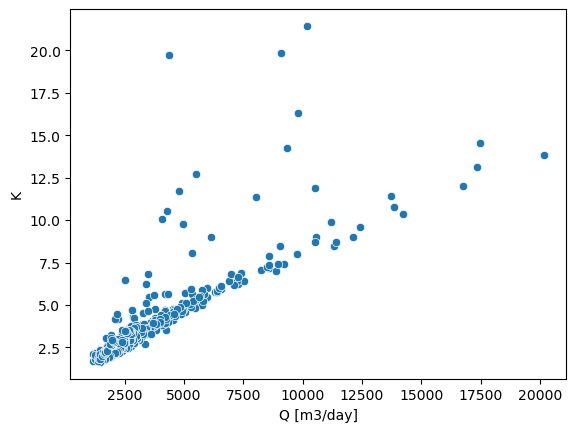

In [12]:
sns.scatterplot(cal_Ks, x='Q [m3/day]', y = 'K')


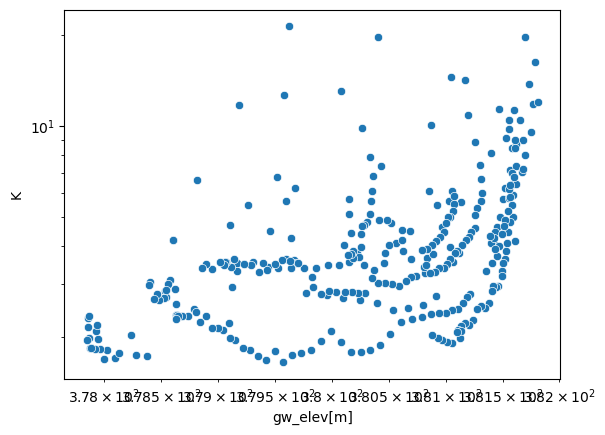

In [214]:
sns.scatterplot(cal_Ks, x = 'gw_elev[m]', y = 'K')
plt.yscale('log')
plt.xscale('log')

In [13]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
x = cal_Ks['Q [m3/day]'].values.reshape(-1, 1)
y = cal_Ks['K'].values
lr.fit(x,y)
slope = lr.coef_[0]
b = lr.intercept_

In [14]:
from functools import partial
def linear_k_q(q, slope, b): 
    return q * slope + b

def exp_k_q(q, slope, b):
    return np.e**(b) * q**slope
partial_f = partial(linear_k_q, slope = slope*10, b= b+10)
partial_exp_f = partial(exp_k_q, slope = slope, b= b)

In [15]:
param_model = ParametrizedKModel(partial_f, w =w, l = l, hs=hs, b=b, sy=sy, dt= dt, kbar=None)

In [16]:
out = param_model.explicit_solve_over_time(n, h_o, q_o, rech, verbose = True)

0.0006738965
k = 21.234089157010775, qs: 309.93542792151953, qin: 1253.4474899999998, h: 377.89001664549505
0.0007152615
k = 13.67242090744411, qs: 199.7229178526908, qin: 1330.3863899999997, h: 377.8960954813668
0.0006866505
k = 12.772967136076256, qs: 186.76144528225774, qin: 1277.1699299999998, h: 377.90195789257496
0.0006881155
k = 12.667187443928093, qs: 185.38453566506612, qin: 1279.8948299999997, h: 377.907842356523
0.0058021065
k = 12.655950366147701, qs: 185.39032886860315, qin: 10791.91809, h: 377.9648666993248
0.0016023115
k = 12.6559976449799, qs: 187.04084372245873, qin: 2980.2993899999997, h: 377.9798842183908
0.001124912
k = 12.669467638622834, qs: 187.6748621880179, qin: 2092.33632, h: 377.9901243337554
0.001025097
k = 12.674641917836762, qs: 188.04821200587457, qin: 1906.6804199999997, h: 377.9993642918629
0.0009934789999999998
k = 12.677688857803025, qs: 188.36120581867712, qin: 1847.8709399999996, h: 378.00828638720793
0.000890648
k = 12.680243227222288, qs: 188.6577

In [17]:
out

timestep           Q           h          k
0         0.0  309.935428  377.890017  21.234089
1         1.0  199.722918  377.896095  13.672421
2         2.0  186.761445  377.901958  12.772967
3         3.0  185.384536  377.907842  12.667187
4         4.0  185.390329  377.964867  12.655950
..        ...         ...         ...        ...
323     323.0  330.922881  382.017587  13.840552
324     324.0  332.850216  382.036559  13.843701
325     325.0  333.829471  382.053195  13.859430
326     326.0  334.549364  382.067800  13.867422
327     327.0  335.154292  382.082413  13.873297

[328 rows x 4 columns]

<Axes: xlabel='datetime', ylabel='h'>

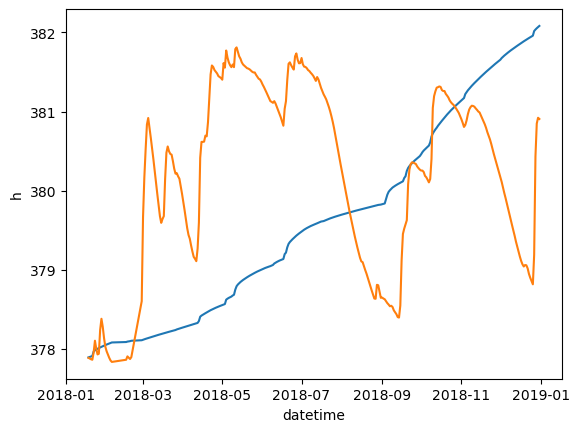

In [18]:
sns.lineplot(out, x=h.index, y='h')
sns.lineplot(h, x = h.index, y = 'gw_elev[m]')

<Axes: xlabel='datetime', ylabel='k'>

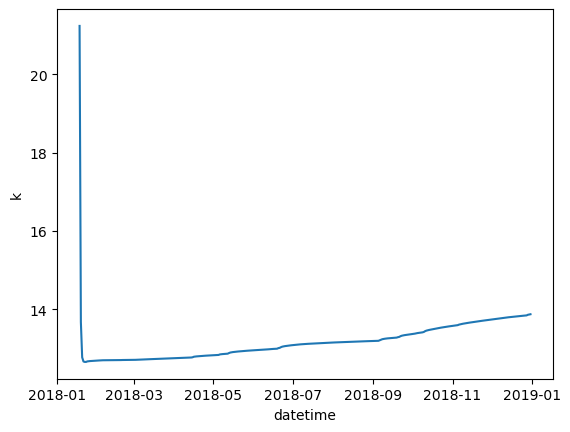

In [19]:
sns.lineplot(out, x = h.index, y = 'k')

<Axes: xlabel='datetime', ylabel='Q'>

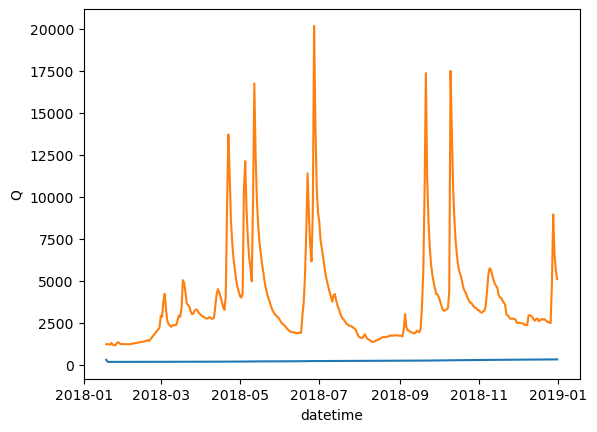

In [20]:
sns.lineplot(out, x=h.index, y='Q')
sns.lineplot(Q[Q.index.isin(h.index)], x = h.index, y = 'Q [m3/day]')